<font color=red>**Note!**</font> This notebook was created by Vahan Geghamyan as a final project of "Data Skills of Computation Economics" in Peking University HSBC Business School, under the instruction of  Prof. Thomas Sargent, Prof. Jake Zhao, Dr. Chase Coleman, and Dr. Spencer Lyon.

**Title**: Introduction to Sequential Monte Carlo Methods: Estimation of Stochastic Volatility Models

 ## Summary
 
---

This report serves three purposes simultaneously. First, it introduces the reader to Sequential Monte Carlo (SMC) Methods, also known as Particle filters. These are advanced methods used in various fields such as robotics, signal processing, financial econometrics, etc. Similar to the Monte Carlo Markov Chains (MCMC) method, SMC methods are used to approximate stationary distributions, but they are designed in a way to efficiently approximate distributions inherent in financial models sequentially. Second, I delve into the world of volatility models to (i) illustrate how/when/why these particle filters can be used and (ii) convince that stochastic volatility models are amazing. Finally, this report combines the estimation methods we learned in class (such as Maximum Likelihood Estimation (MLE), Method of Moments (MM), and Simulated Method of Moments (SMM)) with the methods introduced in the report to estimate the parameters of the model and predict the volatility with the help of Simulated Maximum Likelihood Estimation (SMLE), which is simply related to MLE in the same way as SMM is related to MM.

The efficacy of the algorithms derived in the text is first tested by applying them to a simulated model, and then they are applied to real financial data. I provide a step-by-step guide to the algorithms by blending theoretical depth and practical application, introducing very fundamental concepts first and then gradually building on them and advancing to advanced methods. Additionally, a detailed explanation of the codes is provided. 

This project assumes that the reader has a solid foundation in probability and statistics. It would be helpful to be familiar with some sampling methods that has been discussed in the class (such as MCMC method)

---

**Keywords:** Particle Filter, Sequential Monte Carlo Methods, Simulated Maximum Likelihood Estimation, Stochastic Volatility Models


**Prerequisites:** 

- Probability and Statistics
- Non-linear Optimization


<font color=red>**Note!**</font> The notebook contains interactive graphs that may not work without running the entire notebook. Since some code takes a few hours to run, I placed non-interactive plots at the end in case the reader wants to go through the notebook without running it. You can check the figures corresponding to each interactive plot by following the redirecting links given in the notes under the interactive plots.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt


from collections import Counter

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets


## Table of Contents

- 1 Introduction
- 2 Data Collection and Processing
    - 2.1 Importing Data
    - 2.2 Asset Returns
- 3 Volatility Models
    - 3.1 Sample Variance Rate
    - 3.2 Weighting Schemes 
        - 3.2.1 ARCH Model and Extensions
        - 3.2.2 The Latent Nature of the Volatilities
    - 3.3 Stochastic Volatility Models
- 4. Sequential Monte Carlo Methods
    - 4.1 Importance Sampling
        - 4.1.1 Mathematical Explanation
        - 4.1.2 Importance Sampling with Resampling (ISR)
        - 4.1.3 Implementation of ISR
    - 4.2 Sequential Importance Sampling with Resampling (SISR)
        - 4.2.1. ISR (High-Dimensional)
        - 4.2.2 Sequential ISR Mathematical Derivation
        - 4.2.3 A Brief Summary of the Subsection
    - 4.3 Sequential Monte Carlo Implementation: Particle Filtering
        - 4.3.1 SISR Algorithms
        - 4.3.2 Applicatioon to Stochastic Volatility Models
    - 4.4 SISR filter with resampling at random times
        - 4.4.1 Weight Degenaracy problem
        - 4.4.2 SISR filter with resampling at random times
    - 4.5 Computing the Likelihood
- 5 Parameter Estimation 
    - 5.1 Spikey Likelihood Function
    - 5.2 Spikey Likelihood Solutions
    - 5.3 Estimation
- 6 Applying the Model to Real Data
- 7 Discussion

# 1 Introduction

Asset volatilities play a crucial role in capturing the market dynamics. An estimate of asset volatility can be obtained by computing the sample variance of the asset returns. However, this only captures the volatility of the observed history of the asset. In many cases, current and/or future volatility is more important. By specifying a model for volatilities, the historical data still can be used to produce estimates of the current and future levels of volatilities and correlations. However, standard volatility models (such as ARCH or GARCH models) assume that time-varying volatility is driven by shocks to the mean of the modeled process. Whereas, stochastic volatility models assume that time-varying volatility is driven not only by shocks to the mean of the modeled process but also by an additional source of randomness (Elliott & Timmermann, 2016). However, for estimating the models, we have to deal with high-dimensional integrals. Because we are going to work with certain distributions from which it is very hard to sample directly, we will use a variant of Monte Carlo Methods that approximates a high-dimensional distribution (such as a $T$-dimensional distribution encountered in time series, where $T$ is the number of observations) sequentially. This approach reduces the problem to a one-dimensional distribution approximation problem. The sequential approach generates discrete distributions, referred to as "particles," which approximate the underlying continuous distribution, avoiding the curse of dimensionality.

This report provides a detailed introduction to SMC techniques, stochastic volatility models, their estimation techniques, and their practical applications in analyzing real data. In Section 2, I import the data and prepare it for future use. Section 3 explores various volatility models, starting with the sample variance rate and extending to more sophisticated methods. Special attention is given to the latent nature of volatilities, a key concept in understanding stochastic volatility models. 

The analysis relies heavily on Sequential Monte Carlo methods, particularly Importance Sampling and its variants, to efficiently approximate distributions when dealing with the high-dimensional integrals inherent in stochastic volatility models. In Section 4, I introduce the reader to these methods, providing a comprehensive mathematical explanation and practical implementation details, assuming only prior knowledge in probability theory and statistics. Additionally, I address challenges that these methods introduce by presenting innovative resampling strategies that strike a balance between accuracy and computational feasibility. In Section 5, I point out the challenges concerning the parameter estimation of these models. In particular, the likelihood functions that we approximate using Monte Carlo methods sometimes are not smooth (that's why I call them "spikey" likelihood functions). This makes the optimizers get stuck in local minimum points and makes the estimation difficult. I discuss the challenges and solutions associated with spikey likelihood functions, providing insights into effective estimation techniques. Then, I test the algorithms derived in the text by applying them to simulated data.

In Section 6, I apply these methods to real-world data. Finally, in Section 7, I conclude by discussing some ways that the model could be extended to better capture the volatility in financial markets following a so-called long memory process. I also discuss some computational techniques that could make the estimation easier and compare the estimation with the technique that we saw in class when learning about Bayesian analysis.

**Note that for this project, I focus on the readability rather than the efficiency of the code.**

# 2 Data Collection and Processing

In this section, I import S&P 500 returns provided by Yahoo Finance with the help of a third-party library, `yfinance`, and prepare it for later use.

## 2.1 Importing Data

`yfinance` is a Python library that provides a simple interface to access financial data from Yahoo Finance. It allows users to fetch historical market data, stock quotes, and related information for various financial instruments, including stocks, indices, and currencies. By leveraging the Yahoo Finance API, `yfinance` enables users to retrieve comprehensive financial data, such as historical prices, dividends, and splits. The library facilitates financial analysis, portfolio management, and research by providing a convenient and efficient way to access up-to-date and historical financial information, making it a popular choice among Python developers in the field of quantitative finance and data analysis.

You have to install the package if you haven't used it before.

In [2]:
# uncomment if you don't have yfinance
#pip install yfinance


In [3]:
import yfinance as yf


In [4]:
# Set the dates of the observations that we want to retrieve
start_date = '2007-01-03'
end_date = '2022-12-31'

# Fetch S&P500 data using yfinance
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

sp500_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,3429160000
2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000
2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000
2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000
2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000


## 2.2 Asset Returns

In [5]:
# Compute log returns using pandas
sp500_data['Log_Returns'] = sp500_data['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))

# Drop the first row since it will have NaN for log returns
sp500_returns_data = sp500_data.dropna()

sp500_returns_data



,Open,High,Low,Close,Adj Close,Volume,Log_Returns
Date,,,,,,,
2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000,0.001228
2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000,-0.006103
2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000,0.002218
2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000,-0.000517
2007-01-10,1408.699951,1415.989990,1405.319946,1414.849976,1414.849976,2764660000,0.001938
...,...,...,...,...,...,...,...
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000,0.005851
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000,-0.004058
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000,-0.012093


These columns provide key information for analyzing stock or asset performance. For this application, we are only interested in `Log_Returns`.

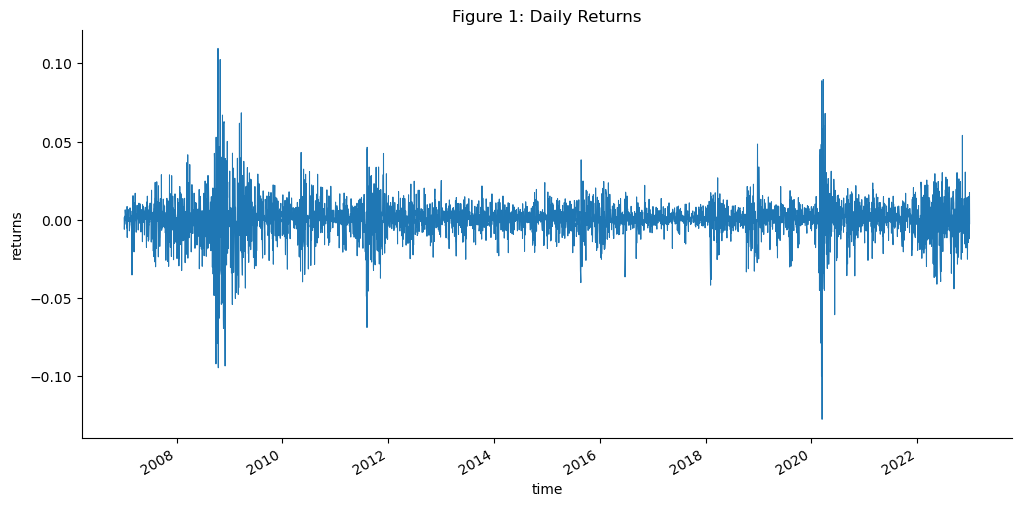

In [6]:
y_d = sp500_returns_data.Log_Returns

def plot_returns(y):
    fig, ax = plt.subplots(figsize=(12, 6))

    y.plot(label="S&P 500", linewidth=0.75, ax=ax)
    plt.title("Figure 1: Daily Returns")

    ax.set_xlabel("time")
    ax.set_ylabel("returns")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

# Plot the daily returns 
plot_returns(y_d)

In [7]:
print(f"We have {y_d.shape[0]} observations at a daily frequency.")


We have 4027 observations at a daily frequency.


# 3 Volatility Models

## 3.1 Sample Variance Rate 

If we define  $\sigma_{n}$ as the volatility of a market variable on day $n$, as estimated at the end of day $n-1$. The square of the volatility, $\sigma_{n}^{2}$, on day $n$ is the variance rate. 

Suppose that the value of the market variable at the end of the day $i$ is $S_{i}$. The variable $u_{i}$ is defined as the continuously compounded return during day $i$ (between the end of day $i-1$ and the end of day $i$ ):

$$
u_{i}=\ln \frac{S_{i}}{S_{i-1}} \tag{1}
$$

An unbiased estimate of the variance rate per day, $\sigma_{n}^{2}$, using the most recent $m$ observations on the $u_{i}$ is

$$
\sigma_{n}^{2}=\frac{1}{m-1} \sum_{i=1}^{m}\left(u_{n-i}-\bar{u}\right)^{2} \tag{2}
$$
where $\bar{u}$ is the mean of the $u_{i} \mathrm{~s}$ :

$$
\bar{u}=\frac{1}{m} \sum_{i=1}^{m} u_{n-i} \tag{3}
$$

The formula in equation (2) is usually is simplified in a number of ways:
1. $u_{i}$ is defined as the percentage change in the market variable between the end of day $i-1$ and the end of day $i$, so that: ${ }^{1}$
2. $\bar{u}$ is assumed to be zero. 

$$
u_{i}=\frac{S_{i}-S_{i-1}}{S_{i-1}} \tag{4}
$$
3. $m-1$ is replaced by $m .$

These three changes make very little difference to the estimates that are calculated, but they allow us to simplify the formula for the variance rate to

$$
\sigma_{n}^{2}=\frac{1}{m} \sum_{i=1}^{m} u_{n-i}^{2}  \tag{5}
$$

where $u_{i}$ is given by equation (1).

#### Example 1.1


<Axes: xlabel='Date'>

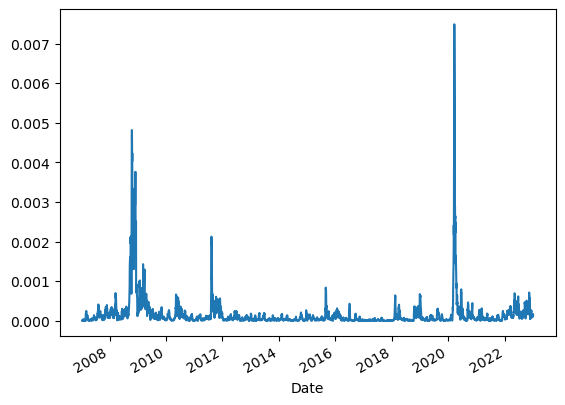

In [8]:
m = 7

# Calculate the mean within the rolling window
rolling_mean = y_d.rolling(window=m).mean()

# Calculate the unbiased estimate of the variance rate according to equation (2)
def variance_rate(x):
    m = len(x)
    mean_u = x.mean()
    return ((x - mean_u)**2).sum() / (m - 1)



# Apply the rolling window and calculate the variance rate
volatility = y_d.rolling(window=m).apply(variance_rate, raw=True)

# Print or use the resulting Series as needed
volatility.plot()



#### Example 1.2


<Axes: xlabel='Date'>

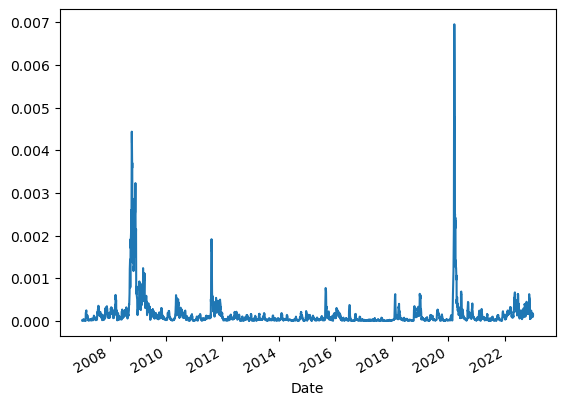

In [9]:
m = 7

# Calculate the mean within the rolling window
rolling_mean = y_d.rolling(window=m).mean()

# Calculate the simplified estimate of the variance rate according to equation (1)
def variance_rate_simplified(x):
    m = len(x)
    return (x**2).sum() / m

# Apply the rolling window and calculate the variance rate
volatility_simplified = y_d.rolling(window=m).apply(variance_rate_simplified, raw=True)

# Print or use the resulting Series as needed
volatility_simplified.plot()


Indeed, as you can see the volatility computed using equation (2) and (5) are almost identical.

Is this accurate? The answer is **NO**. I will not spend too much time discussing why, but curious readers can refer to Chapter 16 of Hull (2012) for more details. I will only mention a few points from the text:

1. **Non-Constant Volatility:** Financial returns often exhibit changing volatility over time, a phenomenon known as volatility clustering. In such cases, using historical returns may not accurately capture the current level of volatility, as it assumes a constant volatility over the entire period.


2. **Time Horizon Dependency:** The choice of the time period (`m` in the example above) over which returns are sampled can affect the sample variance. Different time horizons may yield different volatility estimates. Shorter time periods may capture more recent market conditions but may be more sensitive to noise, while longer periods may smooth out short-term fluctuations but may not reflect the current market dynamics.


3. **Serial Correlation:** Financial returns may exhibit serial correlation, where the returns in one period are related to the returns in the preceding periods. If this correlation is not properly accounted for, it can affect the accuracy of volatility estimates. 

To address some of these issues, financial analysts often use more sophisticated models for estimating volatility, such as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models. These models take into account the time-varying nature of volatility and provide a more nuanced and dynamic estimate of current volatility based on historical data.


## 3.2 Weighting Schemes 
### 3.2.1 ARCH Model and Extensions 

Equation (5) gives equal weight to $u_{n-1}^{2}, u_{n-2}^{2}, \ldots, u_{n-m}^{2}$. Our objective is to estimate the current level of volatility, $\sigma_{n}$. It therefore makes sense to give more weight to recent data. A model that does this is

$$
\sigma_{n}^{2}=\sum_{i=1}^{m} \alpha_{i} u_{n-i}^{2}  \tag{6}
$$

The variable $\alpha_{i}$ is the amount of weight given to the observation $i$ days ago. The $\alpha$ 's are positive. If we choose them so that $\alpha_{i} < \alpha_{j}$ when $i > j$, less weight is given to older observations. The weights must sum to unity, so that

$$
\sum_{i=1}^{m} \alpha_{i}=1
$$

An extension of the idea in equation (6) is to assume that there is a long-run average variance rate and that this should be given some weight. This leads to the model that takes the form

$$
\sigma_{n}^{2}=\gamma V_{L}+\sum_{i=1}^{m} \alpha_{i} u_{n-i}^{2} \tag{7}
$$

where $V_{L}$ is the long-run variance rate and $\gamma$ is the weight assigned to $V_{L}$. Since the weights must sum to unity, we have

$$
\gamma+\sum_{i=1}^{m} \alpha_{i}=1 \tag{8}
$$

This is known as an $\operatorname{ARCH}(m)$ model. It was first suggested by Engle (1982).  

The estimate of the variance is based on a long-run average variance and $m$ observations. The older an observation, the less weight it is given. Defining $\omega=\gamma V_{L}$, the model in equation (7) can be written

$$
\sigma_{n}^{2}=\omega+\sum_{i=1}^{m} \alpha_{i} u_{n-i}^{2} \tag{9}
$$


If we let the weights, $\alpha_{i}$, decrease exponentially as we move back through time in equation (6), we can obtain a model that is equivalent to the exponentially weighted moving average (EWMA) model. If we also take into account the long-run variance, as we did in equation (9), we can obtain a model that is equivalent to the GARCH(1, 1) model proposed by Bollerslev (1986). This can of course be extended to GARCH(p, q). See Hull (2012) Chapter 16 for more details. For other extensions see (Elliott & Timmermann, 2016).

### 3.2.2 The Latent Nature of the Volatilities

The latent (unobservable) nature of volatilities arises from the fact that they are often not explicitly recorded or observed in datasets. Instead, volatility is a hidden or unobservable variable that influences the characteristics of the observed data. This can be seen in different ways.

One way to see this is to acknowledge that **when we want to compute the volatility of a time series at a fixed time $t$, we need a sample (on the frequency domain); however, we only observe one realized value at time $t$.**
 
Modeling volatilities as a latent process acknowledges that volatility is not directly observable but can be inferred from the observed data. By treating volatility as a latent process, models like ARCH and GARCH account for the dynamic and evolving nature of volatility, capturing patterns and dependencies that might be missed by simpler approaches. **In Equation (9), this latency can also be seen if we acknowledge that $\{u_t\}_{t=0}^{\infty}$ is unobservable, and we have to use the estimated residuals to obtain estimated values.**

#### Example 2
Let's look at an example and see how the estimated volatility will change if we use ARCH(1, 1) instead of equation (5). This is only for comparison purposes, and it's not the core of the project, so I'll skip some technicalities. ARCH(1, 1) can be implemented with the code below.


In [10]:
# uncomment if you don't have arch
# pip install arch


Iteration:      1,   Func. Count:      5,   Neg. LLF: 26376.369120839743
Iteration:      2,   Func. Count:     13,   Neg. LLF: 8634.383403081618
Iteration:      3,   Func. Count:     20,   Neg. LLF: 6463.9637552630265
Iteration:      4,   Func. Count:     25,   Neg. LLF: 6396.5150412481835
Iteration:      5,   Func. Count:     30,   Neg. LLF: 6396.035078138656
Iteration:      6,   Func. Count:     34,   Neg. LLF: 6396.030874952756
Iteration:      7,   Func. Count:     38,   Neg. LLF: 6396.030864516533
Iteration:      8,   Func. Count:     41,   Neg. LLF: 6396.030864516568
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6396.030864516533
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


<Axes: xlabel='Date'>

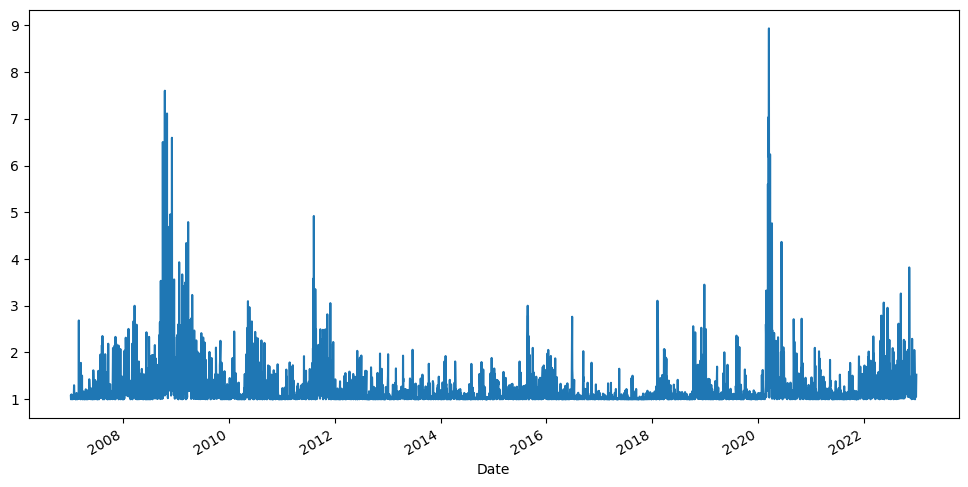

In [11]:
from arch import arch_model

# Rescale the data
data = 100*y_d

# Define the ARCH(1, 1) model
model = arch_model(data, vol='arch', p=1, q=1)

# Fit the model
results = model.fit()

results.conditional_volatility.plot(figsize=(12, 6))


ARCH(1, 1) captured the dynamic volatility patterns better by solving the issues mentioned in the section 2.1. We can see the result above. Isn't this enough? Again, the answer is **NO**.

Standard volatility models (such as ARCH or GARCH models) assume that time-varying volatility is driven by shocks to the mean of the modeled process. Whereas, stochastic volatility models assume that time-varying volatility is driven not only by shocks to the mean of the modeled process but also by an additional source of randomness (Elliott & Timmermann, 2016).



## 3.3 Stochastic Volatility Model


Stochastic volatility models are used to model heteroskedasticity in financial asset returns. A standard stochastic volatility model is given by

\begin{align}
y_{t} &= \exp \left( \frac{x_{t}}{2} \right) \varepsilon_{t}, & \varepsilon_{t} &\sim \mathcal{N}(0,1), \tag{10}\\
x_{t} &= \mu + \phi \left( x_{t-1} - \mu \right) + \sigma_{\eta} \eta_{t}, & \eta_{t} &\sim \mathcal{N}(0,1). \tag{11}
\end{align}


Where $\{{y}_{t}\}_{t=1}^T$ is a series of returns for a particulr asset, and $\{{x}_{t}\}_{t=0}^T$, is a series of unobservable factors that represent the volatility, usually we set $x_t = log(\sigma_{y})$. 


The task is to carry out inference on $\theta = (\mu, \phi, \sigma_{\eta})$, the parameters of the SV model based on a sequence of returns $\{{y}_{t}\}_{t=1}^T$. 

This model can be calibrated by using the method of moments (Taylor, 1982). A difficulty with using moment based estimators for continuous time SV models is that it is not straightforward to compute the moments. Other methods, such as Simulated Method of Moments (SMM), or Simulated Maximum Likelihood (SML) can be used instead. 

The SMM or SML methods are feasible because equations $(10)$ and $(11)$ define a model and each can represents a well defined conditional density. In particular, $p\left({y}_{t} \mid {x}_{t} ; \theta\right)$ and $p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)$ correspond to $(10)$ and $(11)$ respectively. These densities are called the observation (or measurement) and transition densities. The latter terminilogy stems from the fact that ${x}_{t}$ is a Markov process. Equations (10)-(11) can aslo be referred to as a state space model. A state space model is a statistical framework that describes the evolution of a system over time by modeling both observed measurements (asset returns in our case) and unobservable states (the log-volatility in our case), typically represented as a latent process with associated dynamics (Eq. 11) and measurement equations (Eq. 10).

However, these methods can only be used for the model calibration and won't give us an estimate or forecast for $\{{x}_{t}\}_{t=0}^T$. For estimating $\{{x}_{t}\}_{t=0}^T$ as well, we have to evaluate high dimensional integrals (as we will see later). 

A natural solution that comes to our mind is that we can use Monte Carlo Methods to implement the integration. However, it is **not that easy**! 


We don't know how to directly draw samples from certain distributions, so before we delve deeper, it will be helpful to review one of the many sampling methods in statistics, particularly, the Importance Sampling (IS) method.


# 4 Sequential Monte Carlo Methods

This section provides a detailed explanation to the SMC methods by blending theoretical depth and practical application, introducing very fundamental concepts first and then gradually building on them and advancing to advanced methods. Additionally, a detailed explanation of the codes is provided.

**Note**: This section combines my own understanding with different sources cited below; however, it is mostly a summary of Creal (2012) and Chen (2003).

## 4.1 Importance Sampling


Importance sampling is a form of Monte Carlo simulation, a method for approximating the properties of a distribution when direct sampling is challenging or inefficient. IS was invented by Kahn and Marshall (1953) and was first used in econometrics by Kloek and van Dijk (1978).

The core idea behind importance sampling is to sample values from a distribution that is easier to work with, rather than directly sampling from the target distribution. This "importance" distribution should ideally have heavier tails than the target distribution, to ensure that the rare but significant outcomes are sampled more frequently. 

Let's consider a random variable $x$ with probability density function $h(x)$ and we want to estimate the expectation of a function $f(x)$, i.e.,  $E[f(x)]$. In this context, we are going to work with conditional distributions, and it wouldn't harm to assume $h(x) = p\left(x \mid y ; \theta\right)$, we can do this because $p\left(x \mid y ; \theta\right)$ is distribution function (i.e., it satisfies all the conditions a function has to have to be called a distribution function) that is indexed by $\theta$. 

### 4.1.1 Mathematical Explanation

Given a function $f$ of the variable $x$, a standard Monte Carlo estimator of the integral then would be

$$
\mathbb{E}\left[f\left(x\right)\right]=\int f\left(x\right) p\left(x \mid y ; \theta\right) d x \tag{12}
$$

this consists of drawing sequences $x$ directly from the target distribution $p\left(x \mid y ; \theta\right)$. 


When direct sampling is difficult or inefficient, we can introduce another distribution, $g\left(x \mid y ; \psi\right)$, from which it is easier to sample. This distributin, $g\left(x \mid y ; \psi\right)$, is called importance distribution or proposal distribution, and it is chosen by the researcher with the restriction that its support covers the support of the target distribution. The variable $\psi$ denotes a vector of tuning parameters which are used to make the proposal distribution approximate the target distribution as closely as possible. The integral of interest is now

Given an importance distribution, $g\left(x \mid y ; \psi\right)$, we can rewrite the expectation as:

$$
\mathbb{E}\left[f\left(x\right)\right]=\int f\left(x\right) \frac{p\left(x \mid y ; \theta\right)}{g\left(x \mid y ; \psi\right)} g\left(x \mid y ; \psi\right) d x \tag{13}
$$

Here, $\frac{p\left(x \mid y ; \theta\right)}{g\left(x \mid y ; \psi\right)}$ acts as a **weighting function**, it adjustes the importance of samples taken from $g\left(x \mid y ; \psi\right)$ by assigning higher weights to the draws that are more likely to be generated by $p\left(x \mid y ; \theta\right)$.

**Algorithm 1**: Importance Sampling

1. Choose an importance distribution $g\left(x \mid y ; \psi\right)$.

2. Draw $N$ samples $x^{(i)}$ from the importance distribution $g\left(x \mid y ; \psi\right)$. This gives us $\{x^{(i)}\}_{i=1}^N$

3. For each sample, compute the weight $w^{(i)} = \frac{p\left(x^{(i)} \mid y ; \theta\right)}{g\left(x^{(i)} \mid y ; \psi\right)}$. And compute the normalized weights $\widehat{w}^{(i)}=\frac{w^{(i)}}{\sum_{j=1}^{N} w^{(j)}}$

4. The estimate of $E[f(x)]$ is then given by the average of the weighted samples: $$\mathbb{E}\left[f\left(x\right)\right] \approx \sum_{i=1}^{N} \widehat{w}^{(i)} f\left(x^{(i)}\right)$$

It can be shown that under some conditions, for a sufficiently large $N$, the law of large numbers applies and we get $$
\mathbb{E}\left[f\left(x\right)\right] = \lim_{N \to \infty} \sum_{i=1}^{N} \widehat{w}^{(i)} f\left(x^{(i)}\right)
$$


**IS is not only for approximating the expectation above!** 

### 4.1.2 Importance Sampling with Resampling (ISR)

It turns out if we treat $\{\widehat{w}^{(i)}\}_{i=1}^N$ as a discrete probability density of the corresponding draws $\{x^{(i)}\}_{i=1}^N$, and if we resample from $\{x^{(i)}\}_{i=1}^N$ with probabilities $\{\widehat{w}^{(i)}\}_{i=1}^N$, then the random draw will the same as if we drawed a random sample from the original distribution that we can't sample from.

To see this let $\{\tilde{x}^{(i)}\}_{i=1}^N$ denote the resampled 

$$\begin{aligned} \mathbb{P}(x \leqslant a) & =\int_{-\infty}^a p(x) d x \\ & =\frac{\int_{-\infty}^a p(x) d x}{\int_{-\infty}^{+\infty} p(x) d x} \\ & =\frac{\int_{-\infty}^{+\infty} p(x) 1_{(-\infty, a)}(x) d x}{\int_{-\infty}^{+\infty} p(x) d x} \\ & =\frac{\int_{-\infty}^{+\infty} \frac{p(x)}{g(x)} 1_{(-\infty, a)}(x) g(x) d x}{\int_{-\infty}^{+\infty} \frac{p(x)}{g(x)} g(x) d x} \\ & =\frac{\mathbb{E}_g\left[\frac{p(x)}{g(x)} 1_{(-\infty, a)}(x)\right]}{\mathbb{E}_g\left[\frac{p(x)}{g(x)}\right]} \\ & \approx \frac{\frac{1}{N} \sum_{i=1}^N \frac{p\left(x^{(i)}\right)}{g\left(x^{(i)}\right)} 1_{(-\infty, a)}\left(x^{(i)}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{p\left(x^{(i)}\right)}{g\left(x^{(i)}\right)}} \\ & =\sum_{i=1}^N \hat{w}^{\left(x^{(i)}\right)} 1_{(-\infty, a)}\left(x^{(i)}\right) \\ & =\hat{\mathbb{P}}(\tilde{x} \leqslant a)\end{aligned} \tag{14}$$

For simplicity, I dropped the coditional arguments from the functions to make the derivation look simpler.


<a id="Interactive_plot_1_go_back"></a>

### 4.1.3 Implementation of ISR

It is very important to understand the algorithm, so I suggest looking at an example below, and if you still have questions, I suggest to watch [this](https://www.youtube.com/watch?v=bZ2sCqj3ACU)
 YouTube video that explaing the intuition behing this algorithm. 
 


In [12]:
# Desired distribution f(x) - 5*chi-square(df=5)
f = lambda x: stats.chi2(df=5).pdf(x)

# Proposed distribution g(x) = exp^{-x}
g = lambda x: np.exp(-x) 

# Implement SIR
def x_tilde(N):
    """
    Takes N as an argument, implements the SIR algorithm,
    and returns the resampled draws.
    """
    # Sample from the proposed distribution
    x = np.random.exponential(scale=1, size=N)
    
    # Compute the weights for each x
    w = f(x)/g(x)

    # Normalize the weights
    W = w/np.sum(w)

    # Resampling step
    x_tilde = np.random.choice(x, N, p=W, replace=True)

    return x_tilde


# Define a list inclusing different values of N for comparison 
N_list = [1000, 10_000, 100_000, 1_000_000]

# Implement SIR for different N
x_dict = {}
for N in N_list:
    x_dict[str(N)] = x_tilde(N)

# Define a function for plotting
def plot(N):
    
    # Draws N samples from a Chi-square distribution with 5 degrees of freedom for comparison
    chi = stats.chi2.rvs(df=5, size=int(N))
        
    fig, ax = plt.subplots()
    
    ax.hist(chi, bins=30, alpha=0.6, density=True, label='Main')
    ax.hist(x_dict[str(N)], bins=30, alpha=0.6, density=True, label='SIR')
    
    ax.set_ylabel('Probability')
    ax.set_title(f"N={N}")
    ax.legend()

# Plot and compare the results 
interact(plot, N=[str(n) for n in N_list])


interactive(children=(Dropdown(description='N', options=('1000', '10000', '100000', '1000000'), value='1000'),…

<function __main__.plot(N)>

<font color="red">**Note:**</font> If you cannot see the interactive plot above, you can view a non-interactive version of the plot in the Figures section. Click [here](#Interactive_plot_1) to go to the Figures.



In the example above, we used an exponential distribution to sample from a chi-squared distribution. And as you can see, the results get better only when $N$ is very large. This is because the approximation relation in (14),  $\mathbb{P}(x \leqslant a) \approx \hat{\mathbb{P}}(\tilde{x} \leqslant a)$, becomes an equality relation, $\mathbb{P}(x \leqslant a) = \hat{\mathbb{P}}(\tilde{x} \leqslant a)$, only when $N$ goes to infinity.


## 4.2 Sequential Importance Sampling with Resampling (SISR)

As we saw in the previous section, it is possible to estimate a distribution function from which we don't know how to draw samples and how to implement numerical integration when it is difficult to solve the integral analytically or when an analytical solution doesn't even exist. 

Now, can we do the same when the probability is multivariate or the integration is multi-dimensional? The answer is YES. **However**, this depends on the size of the dimension we are discussing. Before delving deeper, it would perhaps be helpful to restate the concept of Importance Sampling from the previous section, but this time for high-dimensional variables.

### 4.2.1. ISR (High-Dimensional)

* Let ${x}_{0: t} = (x_0, x_1, ..., x_t)$ and ${y}_{1: t} = (y_1, y_2, ..., y_t)$


* We want to estimate the entire joint distribution $p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right)$. Given a function $f$ of the random vector ${x}_{0: t}$, a standard Monte Carlo estimator of the integral


$$
\mathbb{E}\left[f\left({x}_{0: t}\right)\right]=\int f\left({x}_{0: t}\right) p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right) d {x}_{0: t} \tag{15}
$$


* Let $g_{0: t}\left({x}_{0: t} \mid {y}_{1: t} ; \psi\right)$ be the importance distribution from which it is easy to sample. The subscript generelizes the function and **indicates that the proposal distribution can change over time**, however we treat it as given in our example. Then,

$$
\mathbb{E}\left[f\left({x}_{0: t}\right)\right]=\int f\left({x}_{0: t}\right) \frac{p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right)}{g_{0: t}\left({x}_{0: t} \mid {y}_{1: t} ; \psi\right)} g_{0: t}\left({x}_{0: t} \mid {y}_{1: t} ; \psi\right) d {x}_{0: t} \tag{16}
$$


* Then the Algorithm 1 is still valid, only this time we draw from a multivariate distribution. After taking $N$ draws $\{{x}_{0: t}^{(i)}\}_{i=1}^{t}$ from the proposal distribution, the importance weights $\left\{w_{t}^{(i)}\right\}_{i=1}^{t}$ are computed by $$w_{t}^{(i)} = \frac{p\left({x}_{0: t}^{(i)} \mid {y}_{1: t} ; \theta\right)}{g_{0: t}\left({x}_{0: t}^{(i)} \mid {y}_{1: t} ; \psi\right)}  \tag{17}$$ and then normalized.


* Given the draws $\left\{{x}_{0: t}^{(i)}, w_{t}^{(i)}\right\}_{i=1}^{t}$, $
\mathbb{E}\left[f\left({x}_{0: t}\right)\right] \approx \sum_{i=1}^{t} f\left({x}_{0: t}^{(i)}\right) \widehat{w}_{t}^{(i)} \tag{18}$, where $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{t} w_{t}^{(j)}}  \tag{19}
$.


What if we want to estimate a probability model with T dimensions, i.e., we are working with a T-dimensional random vector, where T exceeds 1000 (such as daily data of an asset for a few years or hourly data for several months)? Then, to obtain satisfactory results, even if we choose N=1000 (recall that N=1000 performed poorly in estimating the distribution for a single variable), some algorithms may become infeasible due to the curse of dimensionality.

When we work with a time series, we often treat a series $\{y_t\}_{t=1}^T$ as a single realization of a T dimensional random vector (or a random process). This means that each time we have to sample a path instead of a single observation, which implies that we have to find a good T-dimensional proposal distribution to successfully apply importance sampling. However, in high dimensional space this is very hard. Another limitation of standard IS for state space models is that the entire expression for the importance weights (17) needs to be recomputed at each iteration. This means that the computational demands of the algorithm grows over time.

A natural way to alliviate this problem is to construct the proposal distribution sequentially, which is the basic idea of the sequential importanse sampling. 

### 4.2.2 Sequential ISR Mathematical Derivation

SIS is a special case of IS where **instead of drawing ${x}_{0: t}$ from a joint proposal distribution, $p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right)$,  we draw from a sequence of conditional distributions.** To do so we rewrite the joint importance distribution recursively as 

$$
p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right) =\frac{p\left({y}_{t} \mid {x}_{t} ; \theta\right) p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)}{p\left({y}_{t} \mid {y}_{1: t-1} ; \theta\right)} p\left({x}_{0: t\color{red}{-1}} \mid {y}_{1: t\color{red}{-1}} ; \theta\right) \tag{20}
.$$


**This is called joint smoothing recursion, it is not hard to derive this equation but because it is too long, the rigorous derivation is given in Section 2 of Creal (2009). For now just treat it as a formula that says under some conditions (that our model satisfies) we can write the joint distribution that we want to sample from as a function of itself in the last period.**


Now, lets recall a fundamental results in probability theory $$P\left(x_1, x_2, \ldots, x_T\right)=P\left(x_T \mid x_1, \ldots, x_{T-1}\right) \cdot P\left(x_1, \ldots, x_{T-1}\right),$$ which is directly implied by Bayes rule, i.e., $$P\left(x_T \mid x_{1: T-1}\right)=\frac{P\left(x_{1: T-1}, x_T\right)}{P\left(x_{1: T-1}\right)}$$
     



Because our proposal function is also a distribution function, this rule applies to it and we can decompose the importance distribution into two parts:

$$
g_{0: t}\left({x}_{0: t} \mid {y}_{1: t} ; \psi\right) \equiv g_{t}\left({x}_{t} \mid {x}_{0: t-1}, {y}_{1: t} ; \psi\right) g_{0: t-1}\left({x}_{0: t-1} \mid {y}_{1: t-1} ; \psi\right). \tag{21}
$$

The time subscript on the importance distribution $g_t$ indicates that either it or its parameters $\psi$ can potentially be chosen at time $t$ and can change over time.

**There are a few things worth mentioning here. Note that we stand at time $t$, and we have a function that describes all the uncertainty we have faced up to today. When we decompose this function, it is factored into a part that encompasses all the uncertainty we faced yesterday, the day before, and so forth, and another part that represents the uncertainty we face about today (or possibly about tomorrow). Because today we already know what happened yesterday, we know not only the exact form of the distribution (which most likely has changed in one day, because yesterday we thought about an uncertainty in one way (when it hadn't happened) but a day later, we view it differently (when it has already occurred)).**

**Mathematically, after we have decomposed the proposal distribution, the second distribution $g_{0: t-1}(x_{0: t-1} | y_{1: t-1} ; \psi)$ is, per particle, a Dirac measure. This means that it places a unit probability mass on each path that has already been simulated in the previous iterations up to time $t-1$, as in the analogy above.**


After decomposing the proposal distribution, instead of drawing $N$ vectors $x_{0:t-1}$ at time $t-1$, a new set of values $\left\{{x}_{t}^{(i)}\right\}_{i=1}^{N}$ are drawn at a fixed time $t$ from the first part of the importance distribution $g_{t}\left({x}_{t} \mid {x}_{0: t-1}, {y}_{1: t} ; \psi\right)$. 


Consequently, a new sequence of paths is obtained by keeping the trajectories of the old draws up to time $t-1$ fixed and appending the newly simulated values to the end of the old trajectories, $\{{x}_{0: t}^{(i)}\}_{i=1}^{N}=\left\{{x}_{0: t-1}^{(i)}, {x}_{t}^{(i)}\right\}_{i=1}^{N}$. 




Substituting $(20)$ and $(21)$ into $(8)$, we obtain

$$
\begin{aligned}
w_{t} & =\frac{p\left({y}_{t} \mid {x}_{t} ; \theta\right) p\left({x}_{t} \mid {x}_{t-1} ; \theta\right) p\left({x}_{0: t-1} \mid {y}_{1: t-1} ; \theta\right)}{p\left({y}_{t} \mid {y}_{1: t-1} ; \theta\right) g_{t}\left({x}_{t} \mid {x}_{0: t-1}, {y}_{1: t} ; \psi\right) g_{0: t-1}\left({x}_{0: t-1} \mid {y}_{1: t-1} ; \psi\right)} \\
& \propto w_{t-1} \frac{p\left({y}_{t} \mid {x}_{t} ; \theta\right) p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)}{g_{t}\left({x}_{t} \mid {x}_{0: t-1}, {y}_{1: t} ; \psi\right)} \\
& \propto w_{t-1} \tilde{w}_{t}
\end{aligned} \tag{22}
,$$

where $$
\tilde{w}_{t}=\frac{p\left({y}_{t} \mid {x}_{t} ; \theta\right) p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)}{g_{t}\left({x}_{t} \mid {x}_{0: t-1}, {y}_{1: t} ; \psi\right)}. \tag{23}
$$

This equation is the key in Sequential IS algorithm, it gives us a formula that says how teh weights in this period are related to the weights last period, this means that the importance weights doesn't need to be recomputed every time, and we can recursively update it.


Note that in equation (22), the densities $p\left({y}_{t} \mid {x}_{t} ; \theta\right)$ and $p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)$ are determined by the model (10)-(11). 


The ratio of densities $\tilde{w}_{t}$ defined in (23) is known as the incremental importance weight. It is the only part of the importance weight that needs computed at each iteration. 

Calculating the incremental weights then does not require the past observations or the entire past trajectories $\left\{{x}_{0: n-2}^{(i)}\right\}_{i=1}^{N}$.

At the end of each iteration, the SIS algorithm produces $N$ simulated paths and importance weights $\left\{{x}_{0: t}^{(i)}, w_{t}^{(i)}\right\}_{i=1}^{N}$, these draws are also known as "particles." **They provide a discrete distribution that approximates the (partially) continuous distribution.**

Estimates of the moments are the same as in standard IS and are

$$
\mathbb{E}\left[f\left({x}_{0: t}\right)\right] \approx \sum_{i=1}^{N} f\left({x}_{0: t}^{(i)}\right) \widehat{w}_{t}^{(i)}, \quad \widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}  \tag{24}
$$

An estimate of the target distribution is given by

$$
p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right) \approx \sum_{i=1}^{N} \widehat{w}_{t}^{(i)} \delta_{{x}_{0: t}^{(i)}}\left({x}_{0: t}\right)   \tag{25}
$$
where $\delta_{{x}_{0: t}^{(i)}}$ denotes a Dirac measure located at ${x}_{0: t}^{(i)}$. 


An estimate of the contribution to the likelihood at time $n$ is

$$
p\left({y}_{t} \mid {y}_{1: t-1} ; \theta\right) \approx \sum_{i=1}^{N} \widehat{w}_{t-1}^{(i)} \tilde{w}_{t}^{(i)}
\tag{26}
$$

which is a function of the normalized weights from last period. This equation will be very important for the parameter estimation stage, and a detailed derivation is given in Section 2 of Cereal (2009).

## 4.3  Sequential Monte Carlo Implementation: Particle Filtering

### 4.3.1 SISR Algorithms 

* **Algorithm 2.1:** Sequential Importance Sampling with Resampling (SISR)

    * At $n=0$, for $i=1, \ldots, N$: 
        * Draw ${x}_{0}^{(i)} \sim g_{0}\left({x}_{0}\right)$ and set $w_{0}^{(i)}=\frac{p\left({x}_{0}^{(i)}\right)}{g_{0}\left({x}_{0}^{(i)}\right)}$.

    * For $t=1, \ldots, T$ :

        * (i) For $i=1, \ldots, N$ draw ${x}_{t}^{(i)} \sim g_{t}\left({x}_{t} \mid {x}_{t-1}^{(i)}, {y}_{t} ; \psi\right)$ and compute the importance weights $w_{t}^{(i)} \propto w_{t-1}^{(i)} \frac{p\left({y}_{t} \mid {x}_{t}^{(i)} ; \theta\right) p\left({x}_{t}^{(i)} \mid {x}_{t-1}^{(i)} ; \theta\right)}{g_{t}\left({x}_{t}^{(i)} \mid {x}_{t-1}^{(i)}, {y}_{t} ; \psi\right)}$.

        * (ii) For $i=1, \ldots, N$ normalize the importance weights: $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}$.

        * (iii) Resample $N$ particles with probabilities $\left\{\widehat{w}_{t}^{(i)}\right\}_{i=1}^{N}$ and for $i=1, \ldots, N$ set $w_{t}^{(i)}=\frac{1}{N}$.


---

Then,
* $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}$


* $\mathbb{E}\left[f\left({x}_{0: t}\right)\right] \approx \sum_{i=1}^{N} f\left({x}_{0: t}^{(i)}\right) \widehat{w}_{t}^{(i)}$



$$
p\left({x}_{0: t} \mid {y}_{1: t} ; \theta\right) \approx \sum_{i=1}^{N} \widehat{w}_{t}^{(i)} \delta_{{x}_{0: t}^{(i)}}\left({x}_{0: t}\right) \tag{27}
$$


For an algorithm that resamples in every time period, an estimate of the contribution to the likelihood at time $n$ is

$$
\begin{aligned}
p\left({y}_{t} \mid {y}_{1: t-1} ; \theta\right) & =\int p\left({y}_{t} \mid {x}_{t} ; \theta\right) p\left({x}_{t} \mid {y}_{1: t-1} ; \theta\right) d {x}_{t} \\
& \approx \frac{1}{N} \sum_{i=1}^{N} \tilde{w}_{t}^{(i)}
\end{aligned}  \tag{28}
$$

If resampling is performed in random time periods such as in Algorithm 4 below, an estimator of contributions to the likelihood is given by

$$
p\left({y}_{t} \mid {y}_{1: t-1} ; \theta\right) \approx \sum_{i=1}^{N} \widehat{w}_{t-1}^{(i)} \tilde{w}_{t}^{(i)}
\tag{29}
$$
which includes (28) as a special case when $\widehat{w}_{t-1}^{(i)}=\frac{1}{N}$ for $i=1, \ldots, N$. Again, equation (29) is very important as it will be used for the parameter estimation stage, and a derivation is given in Section 2 of Creal(2009).


Before look at an example talk about the proposal distribution.


Different particle filtering algorithms are obtained by different choices of the incremental importance distribution $g_{t}({x}_{t} \mid {x}_{t-1}, {y}_{t} ; \psi)$. 

Note that in equation (21) the time subscript on the importance distribution indicates that either it or its parameters $\psi$ can potentially be chosen at time $t$ and can change over time. This is in most general case, and as you will see we can assume a function whose parameters change but the distribution remains te same. We can also reduce the conditioning information in the importance distribution so that $g_{0: t}({x}_{0: t} \mid {y}_{1: t} ; \psi)$ becomes $g_{t}({x}_{t} \mid {x}_{t-1}, {y}_{t} ; \psi)$.

To implement the SISR algorithm, we can do another simplificaton. By selecting the conditional proposal distribution at each iteration to be the transition density $g_{t}({x}_{t} \mid {x}_{0: n-1}, {y}_{1:n};\psi)=p({x}_{t} \mid {x}_{t-1} ; \theta)$ implied by the dynamics our model, i.e., by equation (11).

This means that the incremental weight function is equal to the measurement density, $\tilde{w}_{t}=p({y}_{t} \mid {x}_{t} ; \theta)$. 


Then the Algorithm 2.1 can be simplified to



* **Algorithm 2.2:** SISR with $g_{t}\left({x}_{t} \mid {x}_{0: n-1}, {y}_{1:n};\psi\right)=p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)$

    * At $n=0$, for $i=1, \ldots, N$: 
        * Draw ${x}_{0}^{(i)} \sim p(x_0;\theta)$ and set $w_{0}^{(i)}=1/N$.

    * For $t=1, \ldots, T$ :

        * (i) For $i=1, \ldots, N$ draw ${x}_{t}^{(i)} \sim p(x_t \mid x_{t-1}^{(i)};\theta)$ and compute the importance weights $w_{t}^{(i)} \propto w_{t-1}^{(i)} p\left({y}_{t} \mid {x}_{t}^{(i)} ; \theta\right)$.

        * (ii) For $i=1, \ldots, N$ normalize the importance weights: $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}$.

        * (iii) Resample $N$ particles with probabilities $\left\{\widehat{w}_{t}^{(i)}\right\}_{i=1}^{N}$ and for $i=1, \ldots, N$ set $w_{t}^{(i)}=\frac{1}{N}$.


---

### 4.3.2 Applicatioon to Stochastic Volatility Models 

Now we are ready to look at our first particle filter. We will do a simulatipn to see how good the technique described above will estimate the distribution for our latent factoe, in this case, log-volatility. 

For simulation let's use our model (10)-(11) with parameter values chosen as $\mu=0.5, \phi=0.985$, and $\sigma_{\eta}^{2}=0.04$.

$$\begin{aligned} y_t=\exp (\frac{x_t}{2}) \varepsilon_t, \varepsilon_t \sim N(0,1) &\Rightarrow y_t \mid x_t \sim N(0, \exp (x_t)) \\  x_t=\mu+\phi(x_{t-1}-\mu)+\sigma_\eta \eta, \eta \sim N(0,1), &\Rightarrow x_t \mid x_{t-1} \sim N(\mu+\phi(x_{t-1}-\mu), \sigma_\eta^2) .\end{aligned} \tag{30}
$$



First, we define a class `SV` which contains functions that sample from the observation and transition distributions implied by (1)-(2) which is given above. It also contains a function that evaluates the conditional density of the observation function. 

In [13]:
class SVM:
    def __init__(self, mu, phi, sigma):
        self.mu = mu
        self.phi = phi
        self.sigma = sigma

    def sample_p_y_x(self, x):
        y = np.exp(x / 2) * np.random.randn()
        return y

    def sample_p_x_xm1(self, xm1):
        x = self.mu + self.phi * (xm1 - self.mu) + self.sigma * np.random.randn()
        return x

    def density_p_y_x(self, y, x):
        return stats.norm.pdf(y, loc=0, scale=np.exp(x / 2))

    
def simulate(Model, T):
    """
    Simulates T observations and latent factors according to the given Model.
    """
    # Allocate space for storing the simulated values
    x = np.zeros(T+1)
    y = np.zeros(T)
    # Set the first observation to a random number
    x[0] = np.random.rand()
    
    # Simulate observations
    for t in range(T):
        x[t+1] = Model.sample_p_x_xm1(x[t])
        y[t] = Model.sample_p_y_x(x[t+1])
        
    return y, x[1:]


In [14]:
np.random.seed(42)

T = 100
# Define the Model 
mu_true, phi_true, sigma_true = 0.5, 0.985, 0.2
Model = SVM(mu_true, phi_true, sigma_true)

# Simulate observations
y, x = simulate(Model, T)


We will look closer at the simulated results later, now we can start looking at the coded version of Algorithm 2.2.

In [15]:
def get_x_Alg_22(Model, y, N):
    """
    Takes a series of observations `y`, and a size of MC simulation `N`,
    implements Algorithm 2.2 according to the given `Model` and returns 
    the filtered values of x and the values of x before resampling.
    """
    # We estimate x for all the observed values y, but we can modify it later
    T = len(y)
    
    # Allocate space
    x_filtered = np.zeros((T+1, N))
    x_initial_sample = np.zeros((T, N))
    w_tilde = np.zeros((T, N))
    w_ = np.zeros(N)

    # Step 1. Sample initial values, set initial weights
    x_filtered[0, :] = np.random.uniform(-2, 2, size=N)
    w = np.ones(N)/N
    
    # Step 2. Filtering 
    # At each time step
    for n in range(T):
        # (i) Simulate N particles, i.e. x_t^i, i=1, ..., N
        for i in range(N):
            # Given x_{t-1} draw x_t (N times)
            x_filtered[n+1, i] = Model.sample_p_x_xm1(x_filtered[n, i])
            # Update the weights recursively
            w_tilde[n, i] = Model.density_p_y_x(y[n], x_filtered[n+1, i])
            w_[i] = w[i] * w_tilde[n, i]
        # (ii) Normalize the weights
        w_ = w_/np.sum(w_)
        
        # Store the particles before resampling for plotting
        x_initial_sample[n,:] = x_filtered[n+1, :]
        
        # (iii) Resample the particles with probabilities given by the normalized weights
        x_filtered[n+1,:] = np.random.choice(x_initial_sample[n,:], N, p=w_, replace=True)

    x_filtered =  x_filtered[1:, :]
    
    return x_filtered, x_initial_sample


Now, let's look at the results. 

In [16]:
# Plotting the results
def plot_x(x_filtered, x_initial_sample, particles=True):
    
    # Compute the mean and quantiles for plotting
    x_mean = np.mean(x_filtered, axis=1)
    x_q25 = np.percentile(x_filtered, 25, axis=1)
    x_q75 = np.percentile(x_filtered, 75, axis=1)
        
    N = x_filtered.shape[1]

    # Set the figure size
    figsize=(10, 4)

    fig, ax = plt.subplots(figsize=figsize) 

    if particles==True:
        # Plot the data
        ax.plot(range(len(x)), x, color='blue')
        for i in range(N):
            ax.scatter(range(len(x_initial_sample[:, i])), x_initial_sample[:, i], s=0.3, alpha=0.7, color='black')
            ax.plot(range(len(x_filtered[:, i])), x_filtered[:, i], alpha=0.05, color='red')
            ax.scatter(range(len(x_filtered[:, i])), x_filtered[:, i], s=1, alpha=0.7, color='red')

    # Plot the summary statistics
    ax.plot(range(len(x_mean)), x_mean, color='black')
    ax.plot(range(len(x_q25)), x_q25, color='black', alpha=0.7)
    ax.plot(range(len(x_q75)), x_q75, color='black', alpha=0.7)
        
    # Create a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--')

    # Get the y-axis limits
    y_min, y_max = ax.get_ylim()

    # Make the y-axis centered around zero
    max_range = max(abs(y_min), abs(y_max))
    ax.set_ylim(-max_range, max_range)

    plt.show()
    

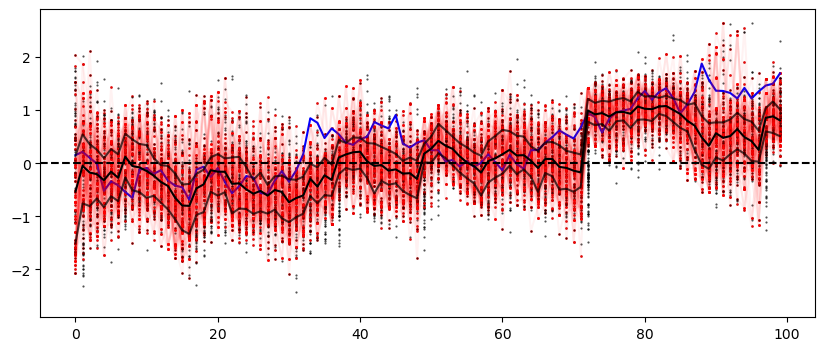

CPU times: user 1.75 s, sys: 8.21 ms, total: 1.76 s
Wall time: 687 ms


In [17]:
%%time

x_filtered_22, x_initial_sample_22 = get_x_Alg_22(Model, y, N=100)    
plot_x(x_filtered_22, x_initial_sample_22)


We can also look at the observed values of $y_t$, $t=1, ..., T$.

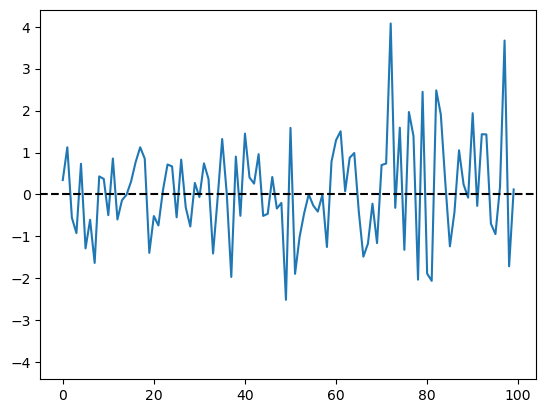

In [18]:
def plot_y(y):
    
    fig, ax = plt.subplots()  
    
    # Plot the data
    ax.plot(range(len(y)), y)

    # Create a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--')

    # Get the y-axis limits
    y_min, y_max = ax.get_ylim()

    # Make the y-axis centered around zero
    max_range = max(abs(y_min), abs(y_max))
    ax.set_ylim(-max_range, max_range)

    plt.show()

plot_y(y)

Now, let's look at what we just did. 

We used the observations of (simulated) asset returns, `y`, assumed that the relationship between the asset returns and its volatility is given by our model (1)-(2), `SV`. And finally, used sequential monte carlo techniques to find an estimated volatility `x_filtered` that is unobservable.

The `plot_y` function above shows us what the simulated asset returns look like. And `plot_x` shows us what is the **"real"** volatility (in blue) and what is the filtered distribution of this volatility (the red dots). In other words, the real volatility is just a realized path of a stochastic process, or it is a single draw of a T dimensional distribution, here we approximated that distribution. The black dots are the initial draws before resampling. This step is where the algorithm does importance sampling and chooses the samples that are more likely to be generated by our stochastic process.

At each point we can also estimate the empirical distribution function of the particles. The`plot_ecdf` function below computes and plots the empirical CDF and PDF for the particals at a given fixed point in time. For comparison, it also plots the CDF of a Standard Normal function. However, note that we do not expect our particles to be distributed normally, it is only for comparison.

Now, let's look at the empirical CDF of teh particles at two different times (small t vs. large t)

## 4.4 SISR filter with resampling at random times



Note that we resample $N$ particles with probabilities $\left\{\widehat{w}_{t}^{(i)}\right\}_{i=1}^{N}$ and after the resamling, for $i=1, \ldots, N$ we set $w_{t}^{(i)}=\frac{1}{N}$. This step will make the weights $w_{t}^{(i)} \propto w_{t-1}^{(i)} p\left({y}_{t} \mid {x}_{t}^{(i)} ; \theta\right)$ poorly approximated. 

But why do we do this? What if we we use this recursion as it is?

* **Algorithm 2.3:** SISR with $g_{t}\left({x}_{t} \mid {x}_{0: n-1}, {y}_{1:n};\psi\right)=p\left({x}_{t} \mid {x}_{t-1} ; \theta\right)$ 2

    * At $n=0$, for $i=1, \ldots, N$: 
        * Draw ${x}_{0}^{(i)} \sim p(x_0;\theta)$ and set $w_{0}^{(i)}=1/N$.

    * For $t=1, \ldots, T$ :

        * (i) For $i=1, \ldots, N$ draw ${x}_{t}^{(i)} \sim p(x_t \mid x_{t-1}^{(i)};\theta)$ and compute the importance weights $w_{t}^{(i)} \propto w_{t-1}^{(i)} p\left({y}_{t} \mid {x}_{t}^{(i)} ; \theta\right)$.

        * (ii) For $i=1, \ldots, N$ normalize the importance weights: $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}$.

        * (iii) **Resample $N$ particles with probabilities $\left\{\widehat{w}_{t}^{(i)}\right\}_{i=1}^{N}$.**


Algorithm 2.2


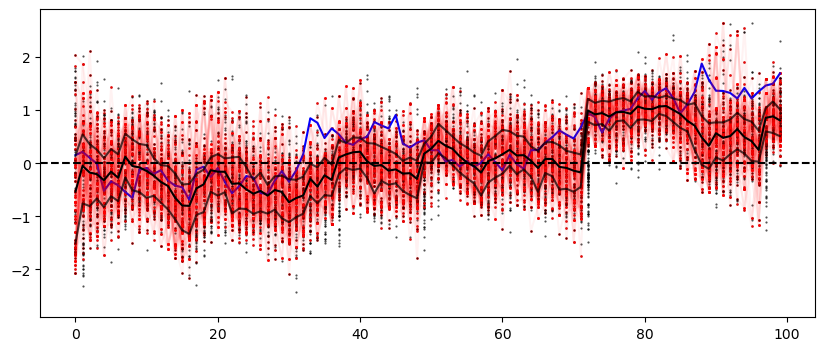

Algorithm 2.3


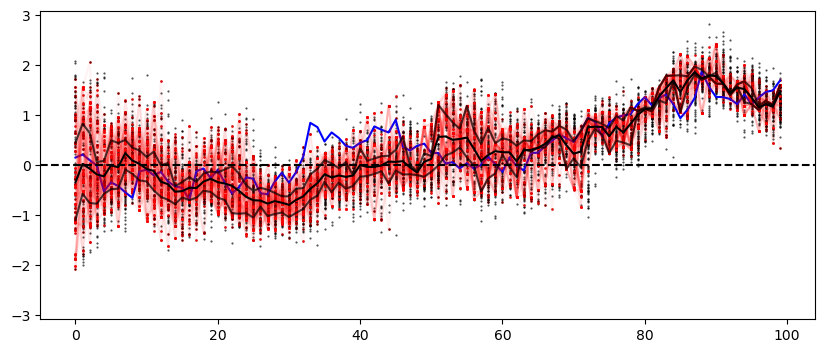

CPU times: user 3.07 s, sys: 25.8 ms, total: 3.1 s
Wall time: 1.19 s


In [19]:
%%time
def get_x_Alg_23(Model, y, N):
    """
    Takes a series of observations `y`, and a size of MC simulation `N`,
    implements Algorithm 2.3 according to the given `Model` and returns 
    the filtered values of x and the values of x before resampling.
    """
    T = len(y)
    
    x_filtered = np.zeros((T+1, N))
    x_initial_sample = np.zeros((T, N))
    w_tilde = np.zeros((T, N))
    w_ = np.zeros(N)

    x_filtered[0, :] = np.random.uniform(-2, 2, size=N)
    w = np.ones(N)/N
    
    for n in range(T):
        for i in range(N):
            x_filtered[n+1, i] = Model.sample_p_x_xm1(x_filtered[n, i])
            w_tilde[n, i] = Model.density_p_y_x(y[n], x_filtered[n+1, i])
            w_[i] = w[i] * w_tilde[n, i]
        w_ = w_/np.sum(w_)
        
        x_initial_sample[n,:] = x_filtered[n+1, :]
        
        # (iii) Resample the particles with probabilities given by the normalized weights
        x_filtered[n+1,:] = np.random.choice(x_initial_sample[n,:], N, p=w_, replace=True)
        # Set w_{t} = w_{t+1}
        w = w_

    x_filtered =  x_filtered[1:, :]
    
    return x_filtered, x_initial_sample

x_filtered_23, x_initial_sample_23 = get_x_Alg_23(Model, y, N=100)    

print("Algorithm 2.2")
plot_x(x_filtered_22, x_initial_sample_22)

print("Algorithm 2.3")
plot_x(x_filtered_23, x_initial_sample_23)


As we can see, in the example above, when we resample at every step, if we don't reset the weights after the resampling step, we can get very good results when estimating the  joint distribution $p({x}_{0: t} \mid {y}_{1: t} ; \theta)$ when t is moderate, and as we continue going forward and t gets large, we can see that teh estimated distribution by Algorithm 2.3 gets concentrated near the true log-volatility. However, recall that this true volatility is just a single path a stochastic process. Also note that compared to Algorithm 2.2, the variace in Algorithm 2.3 is lower (for 0<t<30 in the two plots above). 

Creal (2009) shows that, in general, repeatedly resampling particles copied from previous generations reduces the number of distinct particles representing the early parts of the joint distribution. If we had a growing T, eventually, the particles will reduce to one point that occurs with probability one. This is why after the resamling, we set $w_{t}^{(i)}=\frac{1}{N}$ for $i=1, \ldots, N$ in Algorithm 2.2. Unfortunately, this has an effect the accuracy of the approximation.

For seeing this we can also look at the empirical cumulative distribution function and the historigram at each point in time. Below I plot them together. For a better looking plots, I recompute the filtered variables again using `N = 10_000`.


In [20]:
# Recompute the filtered variables again using `N = 10_000`
X_plot_22, _ = get_x_Alg_22(Model, y, N=10_000)
X_plot_23, _ = get_x_Alg_23(Model, y, N=10_000)

<a id="Interactive_plot_2_go_back"></a>


In [21]:
def Compare_densities(x_plot_22, x_plot_23):
    plot_titles = {0: 'Algorithm 2.2',
                   1: 'Algorithm 2.3'}

    # Compute the ECDF for each Algorithm
    def ECDF(data):
        sorted_data = np.sort(data)
        n = len(data)
        y = np.arange(1, n + 1) / n
        return sorted_data, y

    ECDF_data = {0: x_plot_22, 1: x_plot_23}

    sorted_dict = {}
    y_dict = {}
    for i in range(2):
        sorted_dict[i], y_dict[i] = ECDF(ECDF_data[i])

    # Compute the CDF for a standard normal distribution
    x_normal = np.linspace(-3, 3, 100)  # Fixed x-axis limits
    y_normal = stats.norm.cdf(x_normal, loc=0, scale=1)
    
    # Compute the density for a standard normal distribution
    y_normal_density = stats.norm.pdf(x_normal, loc=0, scale=1)

    # Set the figure size
    figsize = (18, 12)

    fig, axes = plt.subplots(2, 2, figsize=figsize)

    for i in range(2):
        # Plot the ECDF
        axes[i, 0].plot(sorted_dict[i], y_dict[i], marker='.', linestyle='none', color='blue')
        axes[i, 0].set_xlim(-4, 4)
        axes[i, 0].set_ylim(0, 1)
        axes[i, 0].set_xlabel('Data')
        axes[i, 0].set_ylabel('CDF')
        axes[i, 0].set_title(f'{plot_titles[i]}: Empirical CDF vs. Standard Normal CDF')
        axes[i, 0].plot(x_normal, y_normal, color='red')

        # Histogram
        axes[i, 1].hist(ECDF_data[i], bins=30, color='blue', alpha=0.2, density=True)
        axes[i, 1].set_xlim(-3, 3)
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].set_xlabel('Value')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].set_title(f'{plot_titles[i]}: Histogram of Data vs Standard Normal PDF')
        axes[i, 1].plot(x_normal, y_normal_density, color='red')

    plt.tight_layout()
    plt.show()

    
T_values = widgets.IntSlider(min=1, max=T-1, step=1, description='t')
plot_interact = lambda T: Compare_densities(X_plot_22[T, :], X_plot_23[T, :])

# Use interact to create the interactive plot
interact(plot_interact, T=T_values)


interactive(children=(IntSlider(value=1, description='t', max=99, min=1), Output()), _dom_classes=('widget-int…

<function __main__.<lambda>(T)>


<font color="red">**Note:**</font> If you cannot see the interactive plot above, you can view a non-interactive version of the plot in the Figures section. Click [here](#Interactive_plot_2) to go to the Figures.


Let's understand what the plot above tells us. First, let's recall what we did. We computed the conditional distribution of the unobservable variables according to Algorithms 2.2, 2.3.

- We can see that at time $t=0$, they are all initialized as a Standard Normal distribution. However, as time goes by, this distribution changes. It is apparent that the weight degeneracy problem is very serious if we use Algorithm 2.3.   

- Algorithm 2.2 gives us a good approximation, but it will reduce the accuracy of the estimation.

We want to designed an algorithm that will balance between bias and variance and provide us with the best approximation in this setup. Next, let's state this issue more formally and see what we can do to solve this issue.


<font color="red">**Note:**</font> The CDF and PDF plotted in red are not the true distribution that we are trying to approximate. They are just the CDF and PDF of a standard normal distribution given for comparison. This will make it easier to get a sense of the mean, variance, kurtosis, and skewness of the approximated distribution by simply looking at it.


### 4.4.1  Weight Degenaracy problem

Resampling means that a new population of particles are replicated from the existing population in proportion to their normalized importance weights. In its simplest form, we draw $N$ random variables with replacement from a multinomial distribution with probabilities $\{\widehat{w}^{(i)}\}_{i=1}^{N}$. Particles with large importance weights are randomly duplicated while particles with small probability are eliminated. 

While resampling is a crucial feature to the success of the particle filter, it is important to understand why particles are resampled and what the side-effects of resampling are. **Resampling reduces the monte carlo variaton, but there is no free lunch, the cost that we have to pay is the bias introduced by the resampling step (bootstrapping).** If we keep doing the recursion according to the Algorithm 2.3, eventually the weights will be degenerated so that they assign 1 to a single particle and 0 to the remaining $N-1$ particles.

If resampled the particles' weights are set equal to any constant, e.g. $w_{t}^{(i)}=\frac{1}{N}$ for $i=1, \ldots, N$, as in Algorithm 2.2, the weights will not to permanently degenerate as in the SIS algorithm. However, this will reduce the accuracy of the approximation of the marginal distribution $p({x}_{t} \mid {y}_{1: t} ; \theta)$as it dependes on equation (22). 

To solve this issue, we would like to perform resampling only when it is necessary.

### 4.4.2 SISR filter with resampling at random times

We saw that the original particle filter of Gordon et al. (1993) carries out resampling every time period. 

To lower the degree of Monte Carlo variation introduced into the estimator, Liu and Chen (1995) suggested resampling only after time periods where the importance weights are unstable. 

They suggested using the effective sample size (ESS) as a measure of weight instability. The ESS is given by

$$
\mathrm{ESS}=\frac{1}{\sum_{i=1}^{t}(\widehat{w}_{t}^{(i)})^{2}}  \tag{31}
$$

and is a number between 1 and $N$. 

If the $\mathrm{ESS}=N$, the interpretation is that the weights are equally balanced and that all $N$ particles are contributing to the estimator. 

At each iteration of the algorithm, the user calculates the ESS and if it drops below a user chosen threshold then resampling is performed. Resampling is therefore performed at random times, see Algorithm 4. The threshold for the ESS is typically chosen to be a percentage of the number of particles, say 0.5 to 0.75 .

Another commonly used measures of weight instability is the coefficient of variation (CV) of Kong et al. (1994). These can be substituted into Algorithm 4 instead of the ESS. The CV is defined as

$$
\mathrm{CV}=[\frac{1}{N} \sum_{i=1}^{N}(N \widehat{w}_{n}^{(i)}-1)^{2}]^{0.5}    \tag{32}
$$

and is a number between zero and $\sqrt{N-1}{ }^{3}$ If all the weights are equal then $\mathrm{CV}=0$ and if one particle has all the probability mass then CV $=\sqrt{N-1}.$  Note that $\mathrm{ESS}=N /(1+\mathrm{CV}^{2})$.







* **Algorithm 3**: SISR filter with resampling at random times

    * At $t=0$, for $i=1, \ldots, N$
        * Draw ${x}_{0}^{(i)} \sim g_{0}({x}_{0})$ and set $w_{0}^{(i)}=\frac{p({x}_{0}^{(i)})}{g_{0}({x}_{0}^{(i)})}$.
    * For $t=1, \ldots, T$ :
        * (i) For $i=1, \ldots, N$ draw ${x}_{t}^{(i)} \sim g_{t}({x}_{t} \mid {x}_{t-1}^{(i)}, {y}_{t} ; \psi)$ and compute the importance weights $w_{t}^{(i)} \propto w_{t-1}^{(i)} \frac{p({y}_{t} \mid {x}_{t}^{(i)} ; \theta) p({x}_{t}^{(i)} \mid {x}_{t-1}^{(i)} ; \theta)}{g_{t}({x}_{t}^{(i)} \mid {x}_{t-1}^{(i)}, {y}_{t} ; \psi)}$.

        * (ii) For $i=1, \ldots, N$ normalize the importance weights: $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{t} w_{t}^{(j)}}$.

        * (iii) Compute the ESS.

        * (iv) If ESS $\leq$ threshold, resample $N$ particles with probabilities $\{\widehat{w}_{t}^{(i)}\}_{i=1}^{t}$ and for $i=1, \ldots, N$ set $w_{t}^{(i)}=\frac{1}{t}$ else, if ESS $>$ threshold, set $w_{t}^{(i)}=\widehat{w}_{t}^{(i)}$ for $i=1, \ldots, N$.




Algorithm 2.2


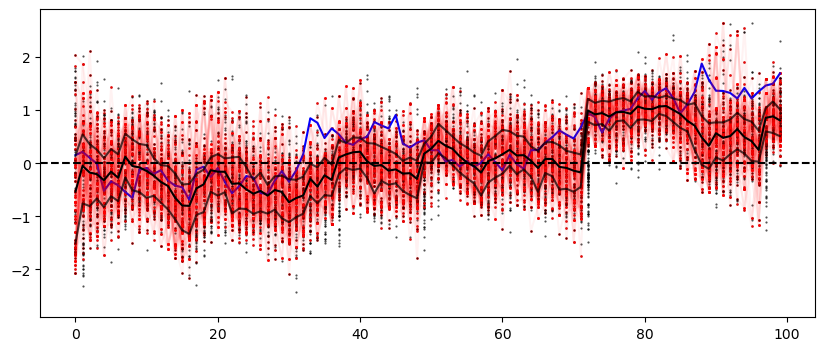

Algorithm 2.3


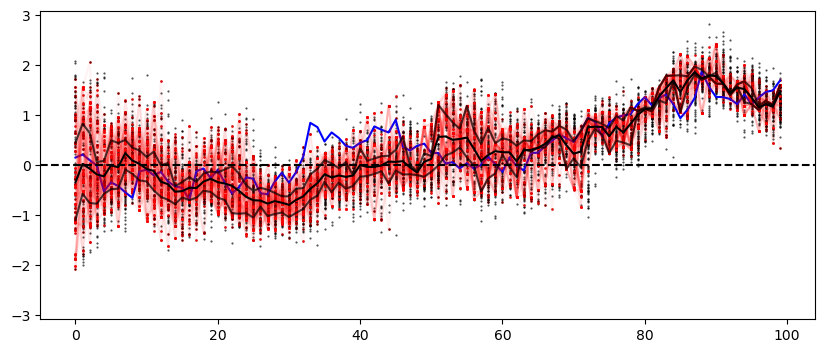

Algorithm 3


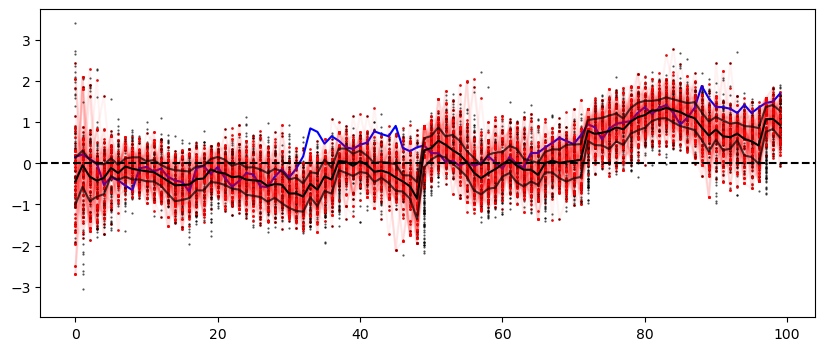

CPU times: user 3.89 s, sys: 20.5 ms, total: 3.91 s
Wall time: 1.56 s


In [22]:
%%time
def get_x(Model, y, N, resample=True):
    """
    Takes a series of observations `y`, and a size of MC simulation `N`,
    implements Algorithm 3 according to the given `Model` and returns 
    the filtered values of x, the weights `W`, the contribution to the 
    likelihood function `w_tilde`, and the values of x before resampling.
    """
    T = len(y)
    
    # Allocate space 
    # Now we are also going to store two terms is step (i) 
    W = np.ones((T, N)) / N
    w_tilde = np.zeros((T, N))
    
    x_filtered = np.zeros((T+1, N))
    x_initial_sample = np.zeros((T, N))
    
    # Step 1. We now sample x_0 from a normal distribution instead of a uniform when |phi| <1
    if abs(Model.phi) < 1:
        var = Model.sigma**2 / (1 - Model.phi**2)
        x_filtered[0, :] = np.random.normal(loc=0, scale=np.sqrt(var), size=N)
    else:
        x_filtered[0, :] = np.random.uniform(-2, 2, size=N)
    
    # Initialize the weights
    w_ = np.zeros(N)
    w = np.ones(N)/N
    
    # Step 2. Implementation
    for n in range(T):
        # (i)
        for i in range(N):
            x_filtered[n+1, i] = Model.sample_p_x_xm1(x_filtered[n, i])
            w_tilde[n, i] = Model.density_p_y_x(y[n], x_filtered[n+1, i])
            w_[i] = w[i] * w_tilde[n, i]
        # (ii)
        w_ = w_/np.sum(w_)

        # (iii) Compute the CV
        CV = np.sqrt(np.mean([(N*w_hat - 1)**2 for w_hat in w_]))
        treshold = np.sqrt(N-1)/3

        # (iv) Resample when CV <= treshold
        x_initial_sample[n,:] = x_filtered[n+1, :]
        
        # Compute the treshold 
        treshold = np.sqrt(N-1)/3
        
        if CV <= treshold:
            x_filtered[n+1,:] = np.random.choice(x_initial_sample[n,:], N, p=w_, replace=True)
            w = np.ones(N)/N 
        else:
            w = w_
        
    W[n, :] = w
        
    x_filtered =  x_filtered[1:, :]
    
    return x_filtered, W, w_tilde, x_initial_sample


# Do the filtering and plot the results
x_filtered, W, w_tilde, x_initial_sample = get_x(Model, y, N=100)  


print("Algorithm 2.2")
plot_x(x_filtered_22, x_initial_sample_22)

print("Algorithm 2.3")
plot_x(x_filtered_23, x_initial_sample_23)

print("Algorithm 3")
plot_x(x_filtered, x_initial_sample)

As you can see, Algorithm 3 outperforms the previous Algorithms 2.2 and 2.3 simply by combining the best features of each. This can be observed by comparing the plot above with the two previous ones. In this plot, the approximated distribution is neither too concentrated nor too spread out; it better describes the underlying process.

**Algorithm 3 will be used for the further analysis.**

We can also look at the likelihood of observing this data. 

## 4.5 Computing the likelihood for a general state space model

The log-likelihood of a time series model is given by the prediction error decomposition

$$
\log L(\theta \mid {y}_{1: T})=\log p({y}_{1}, \ldots, {y}_{T} ; \theta)=\sum_{t=1}^{T} \log p({y}_{t} \mid {y}_{1: t-1} ; \theta)  \tag{32}
$$

The particle filter's approximation of the likelihood function for a single observation was given in (20). It is an unbiased estimator. Taking the log of this approximation and summing over all the observations gives

$$
\log L(\theta \mid {y}_{1: T}) \approx \sum_{t=1}^{T} \log [\sum_{i=1}^{t} w_{t-1}^{(i)} \tilde{w}_{t}^{(i)}] \tag{33}
,$$

where $\widehat{w}_{t}^{(i)}=\frac{w_{t}^{(i)}}{\sum_{j=1}^{N} w_{t}^{(j)}}$ and $\tilde{w}_{t}^{(i)}$ is given by equation (14).

The particle filters estimator of the likelihood can be used in hypothesis testing as well as in parameter estimation.


Let's see what is the log-likelihood of observing our simulated data, `y`, given the parameters that generated it, `mu, phi, sigma = 0.5, 0.985, 0.2`.

In [23]:
%%time
def logLikelihood(W, w_tilde):
    ll_val = np.sum([np.log(W[t, :] @ w_tilde[t, :]) for t in range(T)])
    return ll_val

true_ll = logLikelihood(W, w_tilde)
- true_ll


CPU times: user 130 µs, sys: 0 ns, total: 130 µs
Wall time: 134 µs


155.9054977956535

This gives us the loglikelihood when the parameters are the true ones. 

# 5 Parameter Estimation


As we saw in the last section, the log-likelihood of the model in (30) is given by equation (33). This means we can use the standard tools we learned in class to estimate the model parameters.

First, note that when calculating the log-likelihood above, we already computed the weights (equation 24) and the incremental contributions to the likelihood (Equation 26). Now, let's define a function that combines what we did in the previous step and does the same for a given observed series `y` and parameters `params`. 


In [24]:
def ll(y, N, params):
    """
    Takes an observed series `y`, a list of model parameters `params`, and the 
    number of draws in SMC stage `N` and returns the log-likelihood `val`.
    """
    # Use all the available data 
    T = y.shape[0]

    # Unpack params according to our model
    mu, phi, sigma = params[0], params[1], params[2]
        
    # Define our model 
    SV_model = SVM(mu=mu, phi=phi, sigma=sigma)
    
    # Get the approximated values of x, weights, and likelihood increments
    x_filtered, W, w_tilde, x_initial_sample = get_x(SV_model, y, N)    

    # Compute the log-likelihood
    val = logLikelihood(W, w_tilde)

    return val



Then we are going to define and implement a function that maximizes the log-likelihood given by function `ll`. 

When optimizing, we also have to make sure we set the right bounds for our values. In particular, $|\phi| < 1$, $\sigma > 0$, and there is no constraint on $\mu$.

In [25]:
def fit(y, params_0, N):
    
    min_me = lambda params: - ll(y, N, params)

    bounds = [(-np.inf, np.inf), (-1, 1), (0, np.inf)]
    
    sol = opt.minimize(min_me, params_0, method="nelder-mead", bounds=bounds)

    return sol


In [26]:
%%time
params_0 = [0.1, 0.1, 0.1] 

sol = fit(y, params_0, N=100)


CPU times: user 2min 13s, sys: 562 ms, total: 2min 13s
Wall time: 2min 13s


In [27]:
print(f"Parameters that generated the data were: {mu_true, phi_true, sigma_true}")
print(f"Parameters that were estimated by Maximum Likelihood method are: {sol.x[0]:.3f}, {sol.x[1]:.3f}, {sol.x[2]:.3f}")

Parameters that generated the data were: (0.5, 0.985, 0.2)
Parameters that were estimated by Maximum Likelihood method are: 0.103, 0.103, 0.103


**Wait!** The computed values are wrong. What could have go wrong?


## 5.1 Spikey Likelihood Function 

For understanding what's the problem let's take a closer look at the log-likelihood function. Below I am going to fix the true `phi` and `sigma`, and then plot the log-likelihood as a function of `mu`.

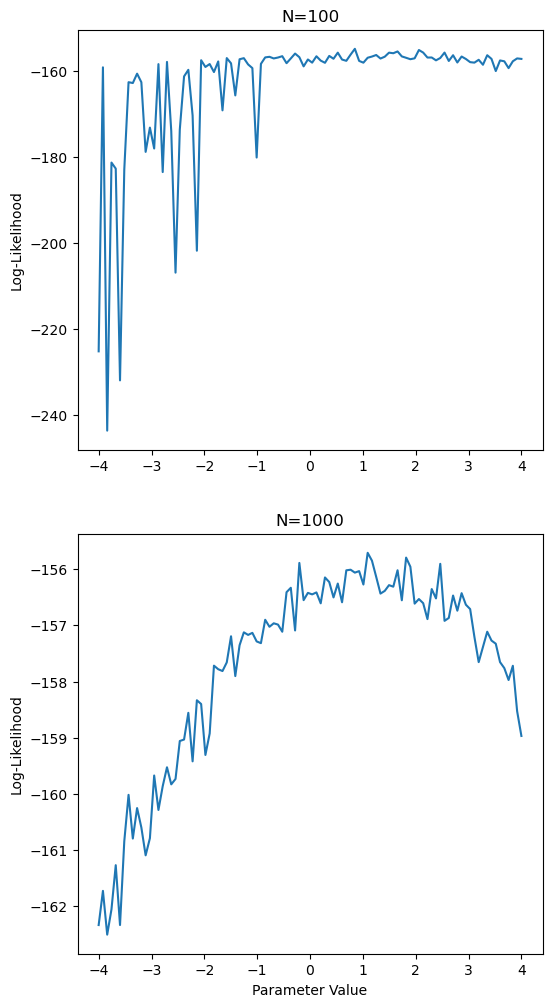

CPU times: user 4min 2s, sys: 986 ms, total: 4min 3s
Wall time: 4min 2s


In [28]:
%%time
def plot_logL(N_list):
    x_plot = np.linspace(-4, 4, 100)
    ll_plot = np.zeros((len(x_plot), len(N_list)))

    for n, N in enumerate(N_list):
        for i, par in enumerate(x_plot):
            ll_plot[i, n] = ll(y=y, N=N, params=[par, 0.985, 0.2])

    fig, axes = plt.subplots(len(N_list), 1, figsize=(6, 12))  

    for n, N in enumerate(N_list):
        axes[n].plot(x_plot, ll_plot[:, n])
        axes[n].set_ylabel('Log-Likelihood')
        axes[n].set_title(f"N={N}")  
    
    axes[-1].set_xlabel('Parameter Value')

    plt.show()

plot_logL([100, 1000])


What we see in the plot above is that if `N` is not large enough, we will get a ver spiky likelihood function, this of course makes the parameter estimation impossible because the optimizers will get stuck somewere that is not necessarily the optimum point.

Our intuition tells us that if we take a larger `N`, say 100000, we can have a smoother likelihood. And yes, that's right! However, to plot the log-likelihood above, I divided the x-axis into 100 points (using `x_plot = np.linspace(-4, 4, 100)`), and for evaluating the likelihood at 100 different points with `N=100_000`, it took the computer about 10 hours to plot the curve. Now, lets see how we can deal with this issue. 

## 5.2 Spikey Likelihood Solutions 

The main reason the log-likelihood is very spike for evan large values of `N` is the **resampling step**. If you modify the algorithm by removing the resampling step, you will see that the likelihood is still spiky for small `N`s but it becomes very smooth when `N=1000`. 

Thus, if we want to get smooth log-likelihood, we need to choose a large `N`. In the literature they usually use `N = 5*10**3`, but even with `N = 10**4` it will take the computer about two days to run the code.

Pitt (2005) discusses the issue of spiky log-likelihood functions and provides solutions. One solution is simply fitting a smooth curve to the resampling probabilities (see step (iv) in Algorithm 3). For more details, I highly recommend the reader to read the paper.

However, I will adopt a simpler approach, accelerating code execution by using NUMBA, which is a Just-In-Time (JIT) compiler for Python. I will not introduce it here in detail because it is not the main focus of the notebook. But you can read "A 5-minute guide to Numba" by following this [link](https://numba.readthedocs.io/en/stable/user/5minguide.html).

Now, let's import the packages that will be usefull. 

In [29]:
from numba import prange, float64, jit
from numba.experimental import jitclass


Next, I am going to modify the function called `get_x` and call it `get_x_jit` . I use the `prange` function when parellalization is feasible (e.g. when we are simulating new particles) and I also change the functions that are not feasible with Numba. 

I will not provide further explanation since explanations for the codes below as they have already been provided above. I will only comment the lines that has been modified.


In [30]:
@jit(nopython=True)
def get_x_jit(Model, y, N):

    # `np.random.coice` function is not compatible with numba, I define my own
    def jit_random_choice(b, N, w):
        choices = np.arange(len(b))
        cumulative_probs = np.cumsum(w)

        result = np.empty(N, dtype=b.dtype)

        for i in range(N):
            rand_val = np.random.rand()
            index = np.searchsorted(cumulative_probs, rand_val, side='right') 
            result[i] = b[index]

        return result

    T = len(y)

    # Allocate space 
    # Now we are also going to store two terms is step (i) 
    W = np.ones((T, N)) / N
    w_tilde = np.zeros((T, N))

    x_filtered = np.zeros((T+1, N))
    x_initial_sample = np.zeros((T, N))

    # Step 1. We now sample x_0 from a normal distribution instead of a uniform
    if abs(Model.phi) < 1:
        var = Model.sigma**2 / (1 - Model.phi**2)
        x_filtered[0, :] = np.random.normal(loc=0, scale=np.sqrt(var), size=N)
    else:
        x_filtered[0, :] = np.random.uniform(-2, 2, size=N)

    # Initialize the weights
    w_ = np.zeros(N)
    w = np.ones(N)/N

    # Step 2. Implementation
    for n in range(T):
        # (i)
        for i in prange(N):
            x_filtered[n+1, i] = Model.sample_p_x_xm1(x_filtered[n, i])
            w_tilde[n, i] = Model.density_p_y_x(y[n], x_filtered[n+1, i])
            w_[i] = w[i] * w_tilde[n, i]
        # (ii)
        w_ = w_ / np.sum(w_)

        # (iii) Compute the CV
        CV_list = np.array([(N*w_hat - 1)**2 for w_hat in w_])
        CV = np.sqrt(np.mean(CV_list))
        treshold = np.sqrt(N-1)/3

        # (iv) Resample when CV <= treshold
        x_initial_sample[n,:] = x_filtered[n+1, :]

        # Compute the treshold 
        treshold = np.sqrt(N-1)/3

        if CV <= treshold:
            # Change `np.random.choice` to `jit_random_choice`
            x_filtered[n+1,:] =jit_random_choice(x_initial_sample[n,:], N, w_)
            w = np.ones(N)/N 
        else:
            w = w_

    W[n, :] = w

    x_filtered =  x_filtered[1:, :]

    return x_filtered, W, w_tilde, x_initial_sample


def ll_jit(y, N, params):
    
    T = y.shape[0]

    mu, phi, sigma = params[0], params[1], params[2]
        
    SV_model = SVM_jit(mu=mu, phi=phi, sigma=sigma)
    
    # Change `get_x` to `get_x_jit`
    x_filtered, W, w_tilde, x_initial_sample = get_x_jit(SV_model, y, N)    

    val = np.sum([np.log(W[t, :] @ w_tilde[t, :]) for t in range(T)])

    return val

def fit_jit(y, params_0, N):
    
    # Change `ll` to `ll_jit`
    min_me = lambda params: - ll_jit(y, N, params)

    bounds = [(-np.inf, np.inf), (-1, 1), (0, np.inf)]
    
    sol = opt.minimize(min_me, params_0, method="nelder-mead", bounds=bounds)

    return sol




As the function `get_x_jit` takes a class `Model` as an input, the input model has to be a "jitclass" (it's just a class that combines functions that can be used in a function that utilizes Just-In-Time Compiling). Thus, I redefine the `SVM` class that has been defined in the previous sections.

In [31]:
spec = [
    ('mu', float64),
    ('phi', float64),
    ('sigma', float64),
]

@jitclass(spec)
class SVM_jit:
    def __init__(self, mu, phi, sigma):
        self.mu = mu
        self.phi = phi
        self.sigma = sigma

    def sample_p_y_x(self, x):
        y = np.exp(x / 2) * np.random.randn()
        return y

    def sample_p_x_xm1(self, xm1):
        x = self.mu + self.phi * (xm1 - self.mu) + self.sigma * np.random.randn()
        return x

    def density_p_y_x(self, y, x):
        return np.exp(-0.5 * ((y - 0) / np.exp(x / 2))**2) / np.sqrt(2 * np.pi * np.exp(x))


Now, let's run the model with a LARGER `N` and see if we can get satisfactory results!

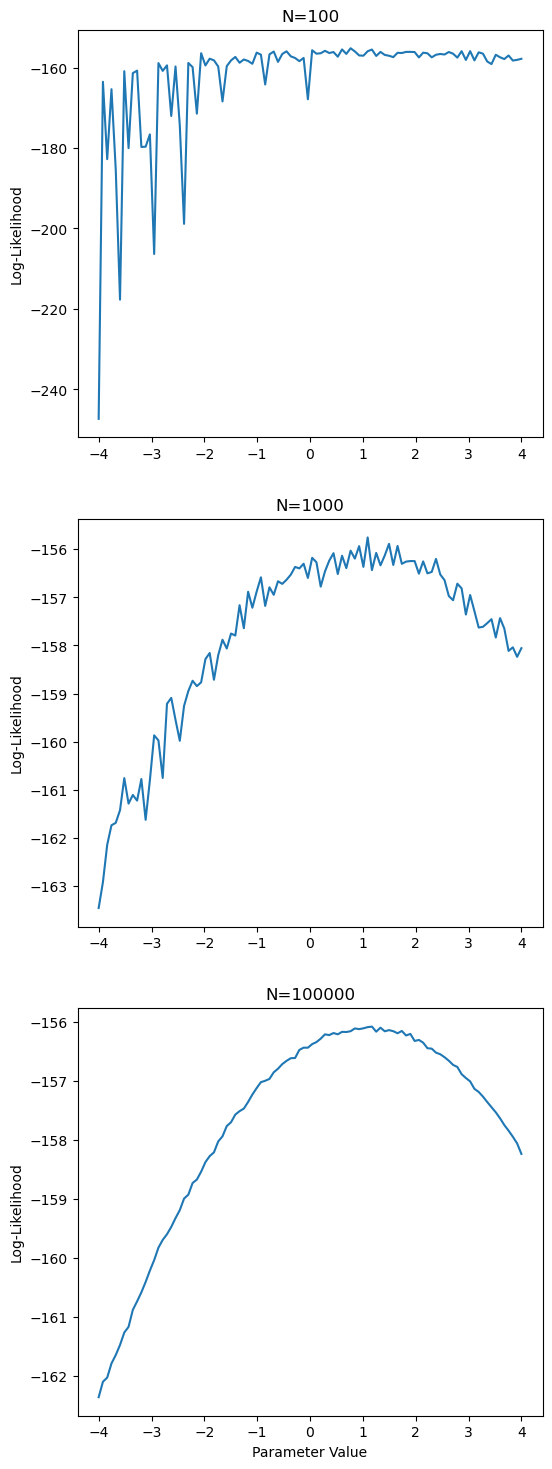

CPU times: user 1min 31s, sys: 1.6 s, total: 1min 32s
Wall time: 1min 32s


In [32]:
%%time
def plot_logL_jit(N_list):
    x_plot = np.linspace(-4, 4, 100)
    ll_plot = np.zeros((len(x_plot), len(N_list)))

    for n, N in enumerate(N_list):
        for i, par in enumerate(x_plot):
            ll_plot[i, n] = ll_jit(y=y, N=N, params=[par, 0.985, 0.2])

    fig, axes = plt.subplots(len(N_list), 1, figsize=(6, 18))  

    for n, N in enumerate(N_list):
        axes[n].plot(x_plot, ll_plot[:, n])
        axes[n].set_ylabel('Log-Likelihood')
        axes[n].set_title(f"N={N}")  
    
    axes[-1].set_xlabel('Parameter Value')

    plt.show()

plot_logL_jit([100, 1000, 100_000])

Yes! Now we can see that as we increase N, we get a smooth log likelihodd and this makes MLE feasible. The disadvantage is that this will require a lot of computationally costly. However, it worth noting that in the univariate IS case in subsection 3.2.3, we also needed N to be at least 100000 to get a good approximation. However, even 100000 can be not enough!


Besides, to plot the log-likelihood above, I divided the x-axis into 100 points (using `x_plot = np.linspace(-4, 4, 100)`), and it took the computer about 10 hours to plot the curves. What if we divided it into 1000 points (using `x_plot = np.linspace(-4, 4, 1000)` instead)? Even with 100,000 points, it wouldn't be enough to achieve a smooth curve, and it would take significantly longer to obtain the results. Additionally, this was done for only one variable; if we applied the same approach to the entire model, it would require days to find the parameters.

## 5.3 Estimation

In [33]:
%%time
np.random.seed(42)

params_0 = [0.1, 0.1, 0.1]

sol = fit_jit(y, params_0, N=100_000)


CPU times: user 8min 47s, sys: 7.85 s, total: 8min 55s
Wall time: 8min 55s


In [34]:
print(f"Parameters that generated the data were: {mu_true, phi_true, sigma_true}")
print(f"Parameters that were estimated by Maximum Likelihood method are: {sol.x[0]:.3f}, {sol.x[1]:.3f}, {sol.x[2]:.3f}")

Parameters that generated the data were: (0.5, 0.985, 0.2)
Parameters that were estimated by Maximum Likelihood method are: 0.430, 0.974, 0.118


In [35]:
print(f"The likelihood at this point is {sol.fun}")

The likelihood at this point is 154.5872926703179


**Finally!** The approximated parameters are very close to the true parameters. 

Now that we know that everything above works fine, it is time to implement the model on the real data.

# 6 Applying the Model to Real Data


Let's look again at the data we used in the Section 1. 

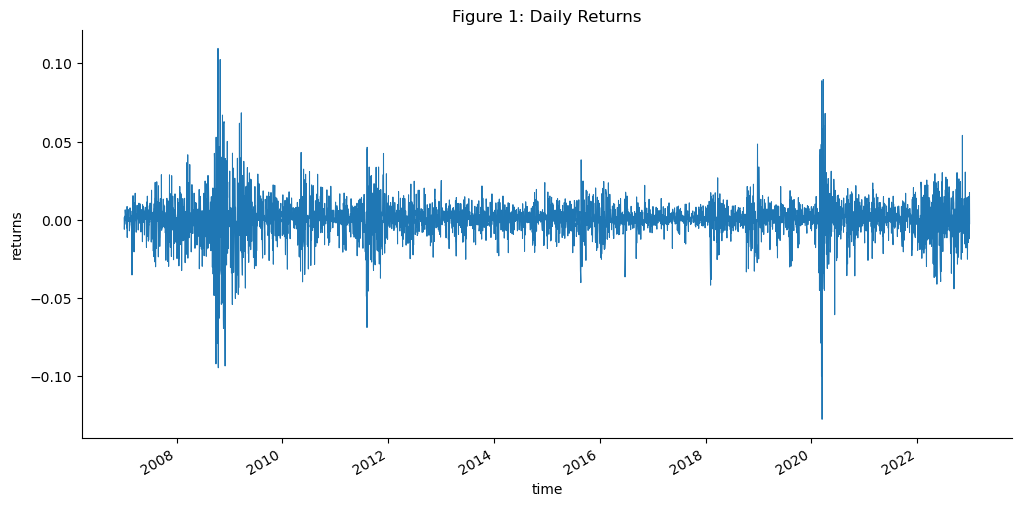

In [36]:
# Plot the daily returns 
plot_returns(y_d)


Now, I apply the same tools used above to estimate the parameters implied by the true data and to obtain the predicted conditional volatilities. Because the sample size is **very** large, I choose `N = 100,000`. This is because compared to the simulated case where I had 100 observations, now I have more than 4000 observations. This means that the log-likelihood is a summation of 4000 expressions expressed by 100,000 particles. This summation will help us to smooth the likelihood function. 

Klass et al. (2006) discuss other ways that make the estimation faster in their work called "Fast Particle Smoothing: If I Had a Million Particles."

In [37]:
%%time
# np.random.seed(42)

N=100_000

params_0 = [-1.398, 0.314, 0.921]

sol_sp500 = fit_jit(data.to_numpy(), params_0, N)



CPU times: user 5h 44min 48s, sys: 10min 45s, total: 5h 55min 33s
Wall time: 5h 55min 57s


In [38]:
print(f"Parameters that were estimated by Maximum Likelihood method are: {sol_sp500.x[0]:.3f}, {sol_sp500.x[1]:.3f}, {sol_sp500.x[2]:.3f}")
print(f"The likelihood at this point is {sol_sp500.fun}")

Parameters that were estimated by Maximum Likelihood method are: 0.196, 0.977, 0.238
The likelihood at this point is 5520.187414985885


Below, I plot the stochastic volatilities predicted by using the model given by equations (10)-(11). However, because what was predicted in reality is not a point estimate but rather a distribution, I plot the mean in blue and different quantiles in various shades of red. Thus, we can think about the predicted volatility as something that is in the darker area of the plot.

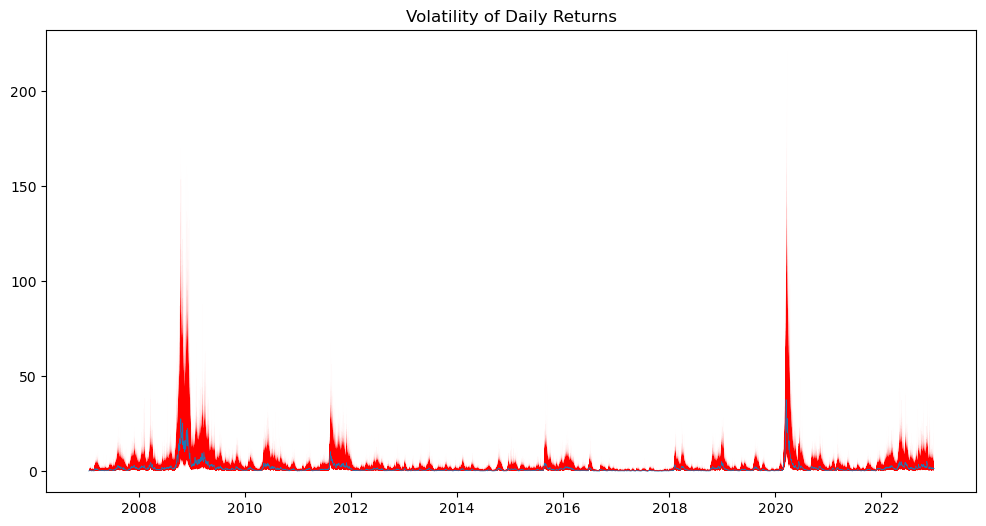

CPU times: user 1min 2s, sys: 311 ms, total: 1min 2s
Wall time: 1min 1s


In [49]:
%%time
# Get the filtered volatility given the maximum likelihood parameters 
mod_sp500 = SVM_jit(*sol_sp500.x)
x_filtered_sp500, _, _, _ = get_x(mod_sp500, data.to_numpy(), N=10_000)

# Plot the estimated volatility
def plot_volatility(x_input):
    x_filtered = x_input[10:, :]
    T = x_filtered.shape[0]
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title("Volatility of Daily Returns")
    ax.plot(data.index[10:], np.exp(x_filtered), color='r', linewidth=0.3, alpha=0.002)
    ax.plot(data.index[10:], np.exp(np.mean(x_filtered, axis=1)), linewidth=0.5)

    
    plt.show()

plot_volatility(x_filtered_sp500)



<a id="Interactive_plot_3_go_back"></a>


**Perfect!** Now we have the volatility of S&P500 returns implied by model (10)-(11). Again, it is not a point estimate but rather a distribution. The blue line represents the mean of this distribution, and the quantiles are plotted in red. Notice that during times when the markets are in turmoil, the red area is very pronounced, whereas during normal times, it closely surrounds the blue line. I don't provide a further comparison with other models, but as we can see from the graph, it looks very similar to what we got using the Bayesian analysis in class. So, I will say that the SMC methods, a.k.a. particle filters, did a very good job in predicting the volatility!

We can also examine the empirical CDF and the histogram of the log-volatility at each point in time. Note how the distribution changes around 2008-2010 and again around 2020-2021.

In [40]:
def plot_ecdf(data, hist=False):

        # Compute the ECDF
        sorted_data = np.sort(data)
        n = len(data)
        y = np.arange(1, n + 1) / n

        # Compute the CDF for a standard normal distribution
        x_normal = np.linspace(-3, 3, 100)  # Fixed x-axis limits
        y_normal = stats.norm.cdf(x_normal, loc=0, scale=1)
        
        # Compute the density for a standard normal distribution
        y_normal_density = stats.norm.pdf(x_normal, loc=0, scale=1)

        # Set the figure size
        figsize = (12, 6)
        
        if hist:
            
            fig, axes = plt.subplots(1, 2, figsize=figsize)

            # Plot the ECDF
            axes[0].plot(sorted_data, y, marker='.', linestyle='none', color='blue')
            axes[0].set_xlim(-4, 4)
            axes[0].set_ylim(0, 1)
            axes[0].set_xlabel('Data')
            axes[0].set_ylabel('CDF')
            axes[0].set_title('Empirical CDF vs. Standard Normal CDF')
            axes[0].plot(x_normal, y_normal, color='red')


            # Histogram
            axes[1].hist(data, bins=30, color='blue', alpha=0.2, density=True)
            axes[1].set_xlim(-3, 3)
            axes[1].set_ylim(0, 1)
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Frequency')
            axes[1].set_title('Histogram of Data vs Standard Normal PDF')
            axes[1].plot(x_normal, y_normal_density, color='red')
            
        else:
            
            fig, ax = plt.subplots(figsize=figsize)

            # Plot the ECDF
            ax.plot(sorted_data, y, marker='.', linestyle='none', color='blue')
            ax.set_xlim(-4, 4)
            ax.set_ylim(0, 1)
            ax.set_xlabel('Data')
            ax.set_ylabel('CDF')
            ax.set_title('Empirical CDF vs. Standard Normal CDF')
            ax.plot(x_normal, y_normal, color='red')


        plt.tight_layout()
        plt.show()


# Create the interactive plot
T_values = widgets.IntSlider(min=1, max=data.shape[0]-1, step=100, description='T')
plot_interact = lambda T: plot_ecdf(x_filtered_sp500[T, :], hist=True)

interact(plot_interact, T=T_values)


interactive(children=(IntSlider(value=1, description='T', max=4026, min=1, step=100), Output()), _dom_classes=…

<function __main__.<lambda>(T)>


<font color="red">**Note:**</font> If you cannot see the interactive plot above, you can view a non-interactive version of the plot in the Figures section. Click [here](#Interactive_plot_3) to go to the Figures.



<font color="red">**Note:**</font> The CDF and PDF plotted in red are not the true distribution that we are trying to approximate. They are just the CDF and PDF of a standard normal distribution given for comparison. This will make it easier to get a sense of the mean, variance, kurtosis, and skewness of the approximated distribution by simply looking at it.

# 7 Discussion

As you can see, we have successfully implemented particle filtering and estimated the parameters of the model using Maximum Likelihood Estimation (MLE). We predicted the volatility of S&P500 returns implied by the model given by equations (10)-(11). In the plot, we illustrated the predicted volatility or the possible range of the volatility. Creal (2012) discusses the advantages of this model over standard volatility models such as ARCH or GARCH, some of which I mentioned in Section 3.

However, it is worth mentioning that this model is only applicable to short-memory volatilities. Shepard (2005) discusses that volatilities exhibit long memory. I will not delve into the details of this issue, but the intuition of a long memory process is that it's a stationary process that can behave like a nonstationary process if not modeled correctly. For more details, see Shepard (2005). The good news is that we still can extend the methods discussed in this report to account for long-memory processes.

In this context, I used a variant of Importance Sampling to approximate the stationary distributions. However, we learned another Monte Carlo method that is very effective at handling this – Monte Carlo Markov Chain methods. As you saw, I used importance sampling to approximate the distribution of the latent variable. Similarly, I could use either rejection sampling or MCMC. However, for the model given in (10)-(11), the SISR algorithm does a pretty good job (Creal, 2012).

In class, we learned that one can also estimate volatility using Bayesian techniques. For convenience, I have included a chunk of the code here:

```python
m = pm.Model()

with m:
    # Data
    data_returns = pm.Data(
        "data_returns", returns["change"].to_numpy(), mutable=False
    )
    
    # Prior on the DoF
    nu = pm.Exponential("nu", 0.1)

    # Prior on the step size of GRW
    step_size = pm.Exponential("step_size", 10)

    # Prior on the volatility
    log_sigma = pm.GaussianRandomWalk(
        "log_sigma",
        sigma=step_size, shape=returns.shape[0],
        init_dist=pm.Normal.dist(0, 0.5)
    )

    # Likelihood of returns
    obs_returns = pm.StudentT(
        "obs_returns", nu=nu, mu=0, lam=pm.math.exp(-2*log_sigma), observed=data_returns
    )
```

In this example that we saw in the class, the model is given by:


\begin{align*}
  \log(r_{t+1}) &\sim \text{StudentT}(\nu, 0, \exp(-2 \log \sigma_{t+1}))\\
  \nu &\sim \text{Exp}(0.1) \\
  \text{stepsize} &\sim \text{Exp}(10) \\
  \log \sigma_{t+1} &= \log \sigma_{t} + \text{stepsize} \varepsilon_{t+1} \\
\end{align*}

As we can see, we only sampled 4 chains with 2000 samples each (8000 in total, excluding 4000 samples for tuning) for each parameter (here you have `2 + returns.shape[0]` parameters). We had to sample about 12 times more to get satisfactory results. Wouldn't it be better to use MCMC instead? The answer is that we could get satisfactory results if we only sampled 8000 samples at each step. This would give us the empirical density functions of the variables that we are interested in. However, the reason we couldn't get satisfactory results even with `N=10000` was that, unlike in the Bayesian case where we only need to approximate conditional distributions, in this case, we had to compute a likelihood function and maximize over it. As discussed in subsections 5.1-5.4, if we use `N` that is not large enough, we will have a non-smooth likelihood function. As already pointed out in subsection 5.3, the main reason the log-likelihood is very spiky for even large values of N is the resampling step.

At each step, we could smooth the densities, but this would require us to make some smoothing assumptions that would determine the bias-variance trade-off (See Chapter 20 of Wasserman (2004) for a detailed discussion of this issue). On the other hand, if we fit a smooth curve to the resampling probabilities in step (iv) in Algorithm 3, we could get smooth likelihoods (Pitt, 2005). This doesn't require us to make any assumptions about the underlying true CDF (See Chapter 7 of Wasserman (2004)). To get a smooth likelihood function, however, I adopted a much simpler approach. I accelerated code execution by using NUMBA, which saved a lot of time. The optimization step with `N=100_000` that would take us two days with 100 observations can now be completed in less than an hours. Applying this to a simulated model confirmed the efficiency of the method. Of course, when it comes to applying the model to real data, this becomes harder if we have a longer time series. Klass et al. (2006) discuss some ways that makes the estimation faster in their work called "Fast Particle Smoothing: If I Had a Million Particles". 

The reader can refer to Cereal (2009) to study the asymptotic properties of Algorithm 2.2 and to Chen (2013) for a discussion on the theoretical properties of Algorithm 3.

Please note that for this project, I focused on the readability rather than the efficiency of the code. Hope you enjoyed reading the report and learning about Particle Filters and Stochastic Volatility Models:D

# Figures

The notebook contains interactive graphs that may not work without running the entire notebook. Since some code takes a few hours to run, I placed non-interactive plots below in case the reader wants to go through the notebook without running it. 

You can navigate back to each interactive plot corresponding to each figure by following the redirecting links provided in the notes under the figures.

<a id="Interactive_plot_1"></a>

### Interactive Plot 1: Implementation of ISR (Subsection 4.1.3)

Click [here](#Interactive_plot_1_go_back) to go back.

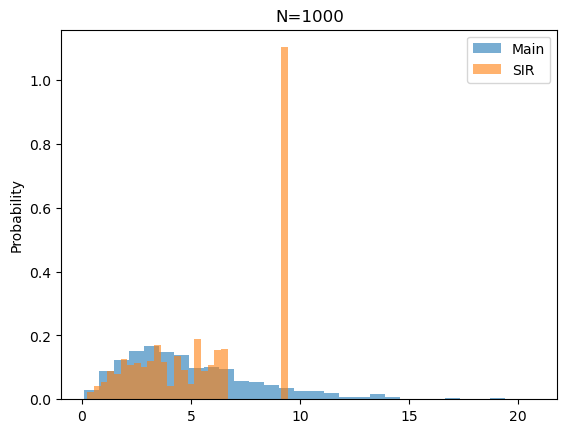

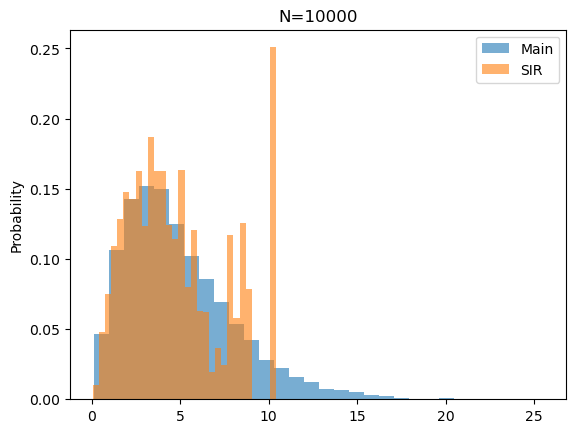

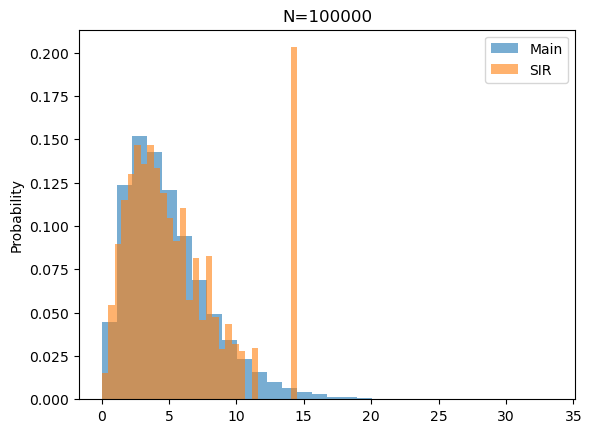

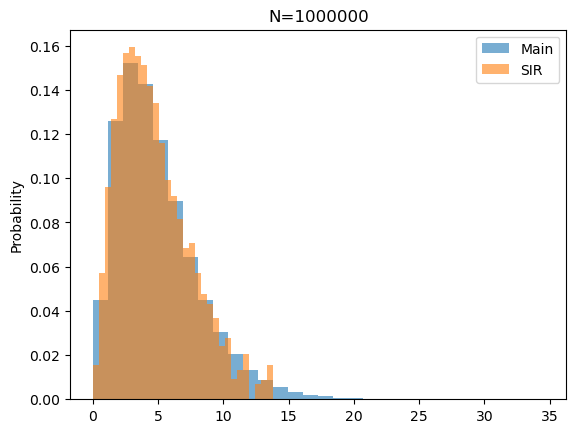

In [41]:
for N in [str(n) for n in N_list]:
    plot(N)
    

<a id="Interactive_plot_2"></a>

### Interactive Plot 2: SISR filter with resampling at random times (Subsection 4.4)

Click [here](#Interactive_plot_2_go_back) to go back.

t (time) is small


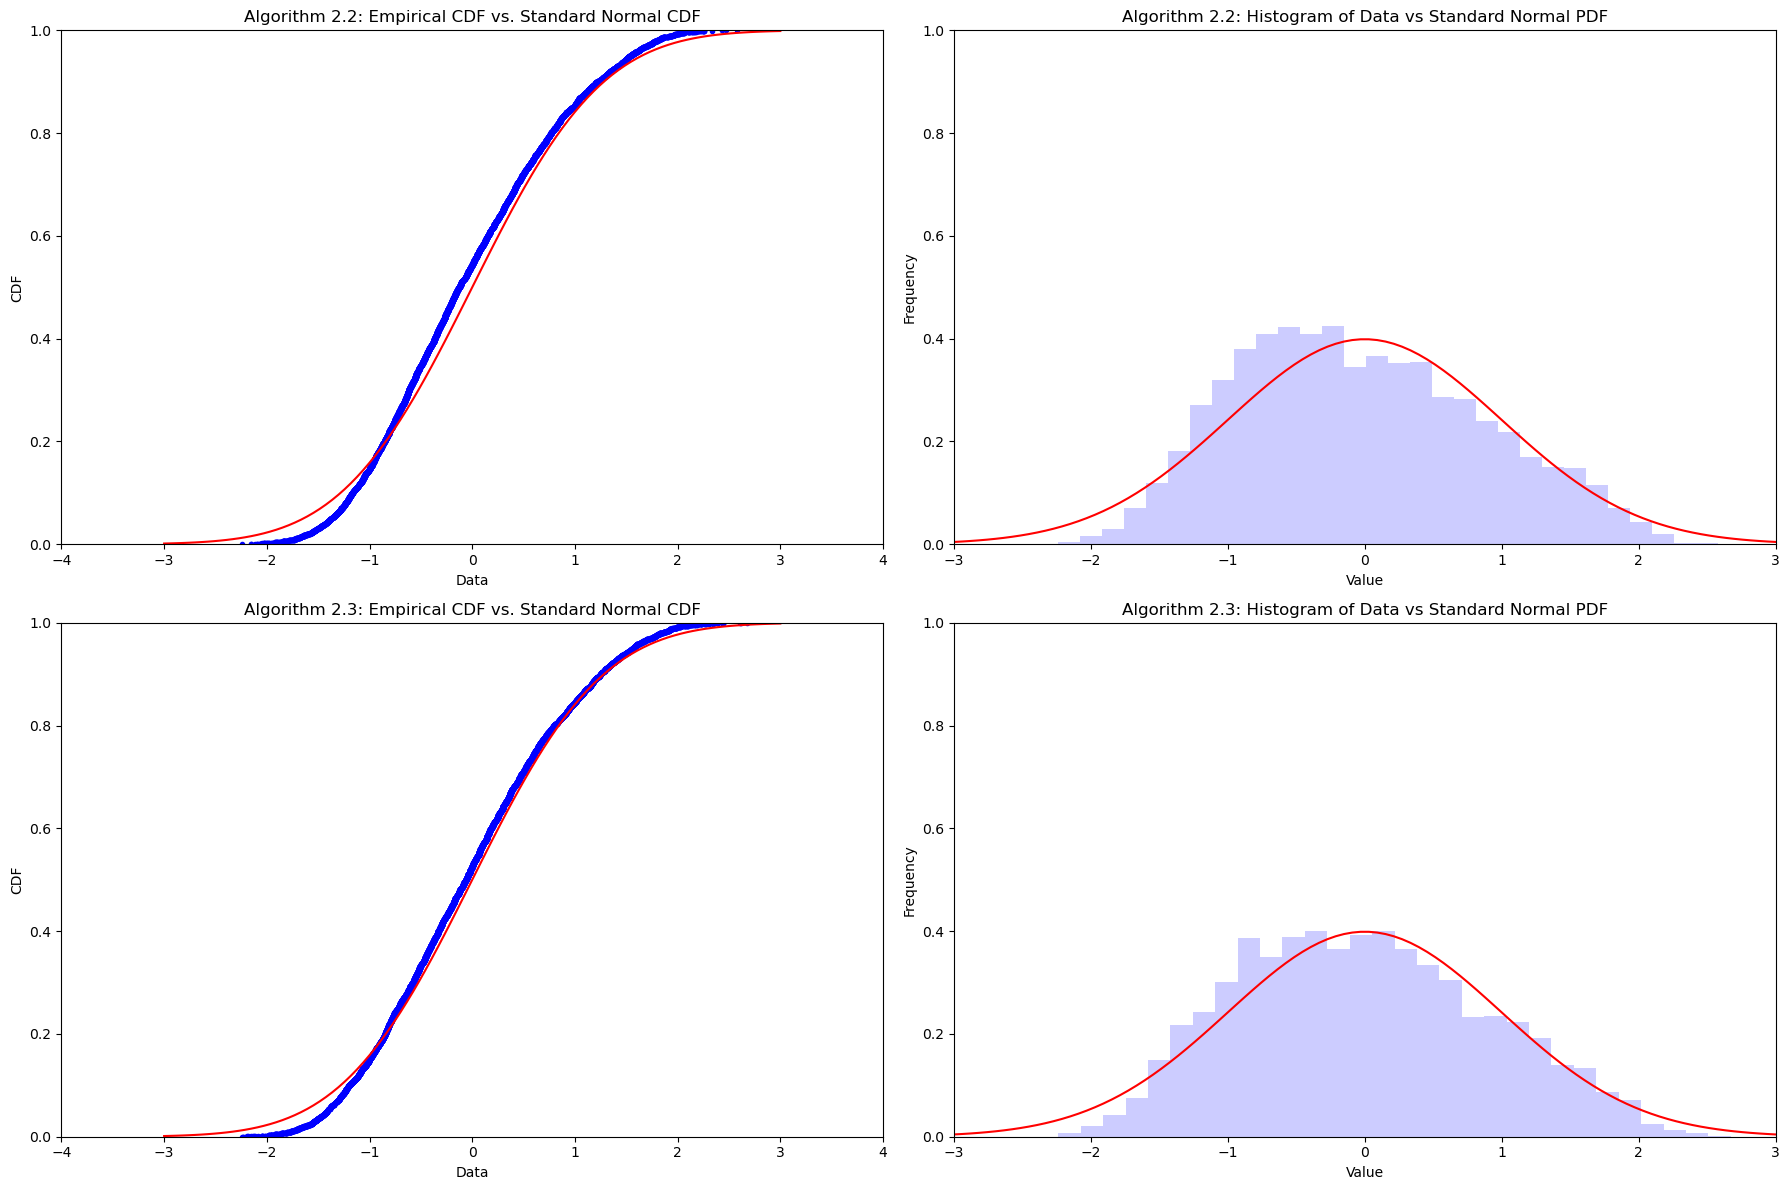

In [42]:
print("t (time) is small")
Compare_densities(X_plot_22[1, :], X_plot_23[1, :])


t (time) is in not too large


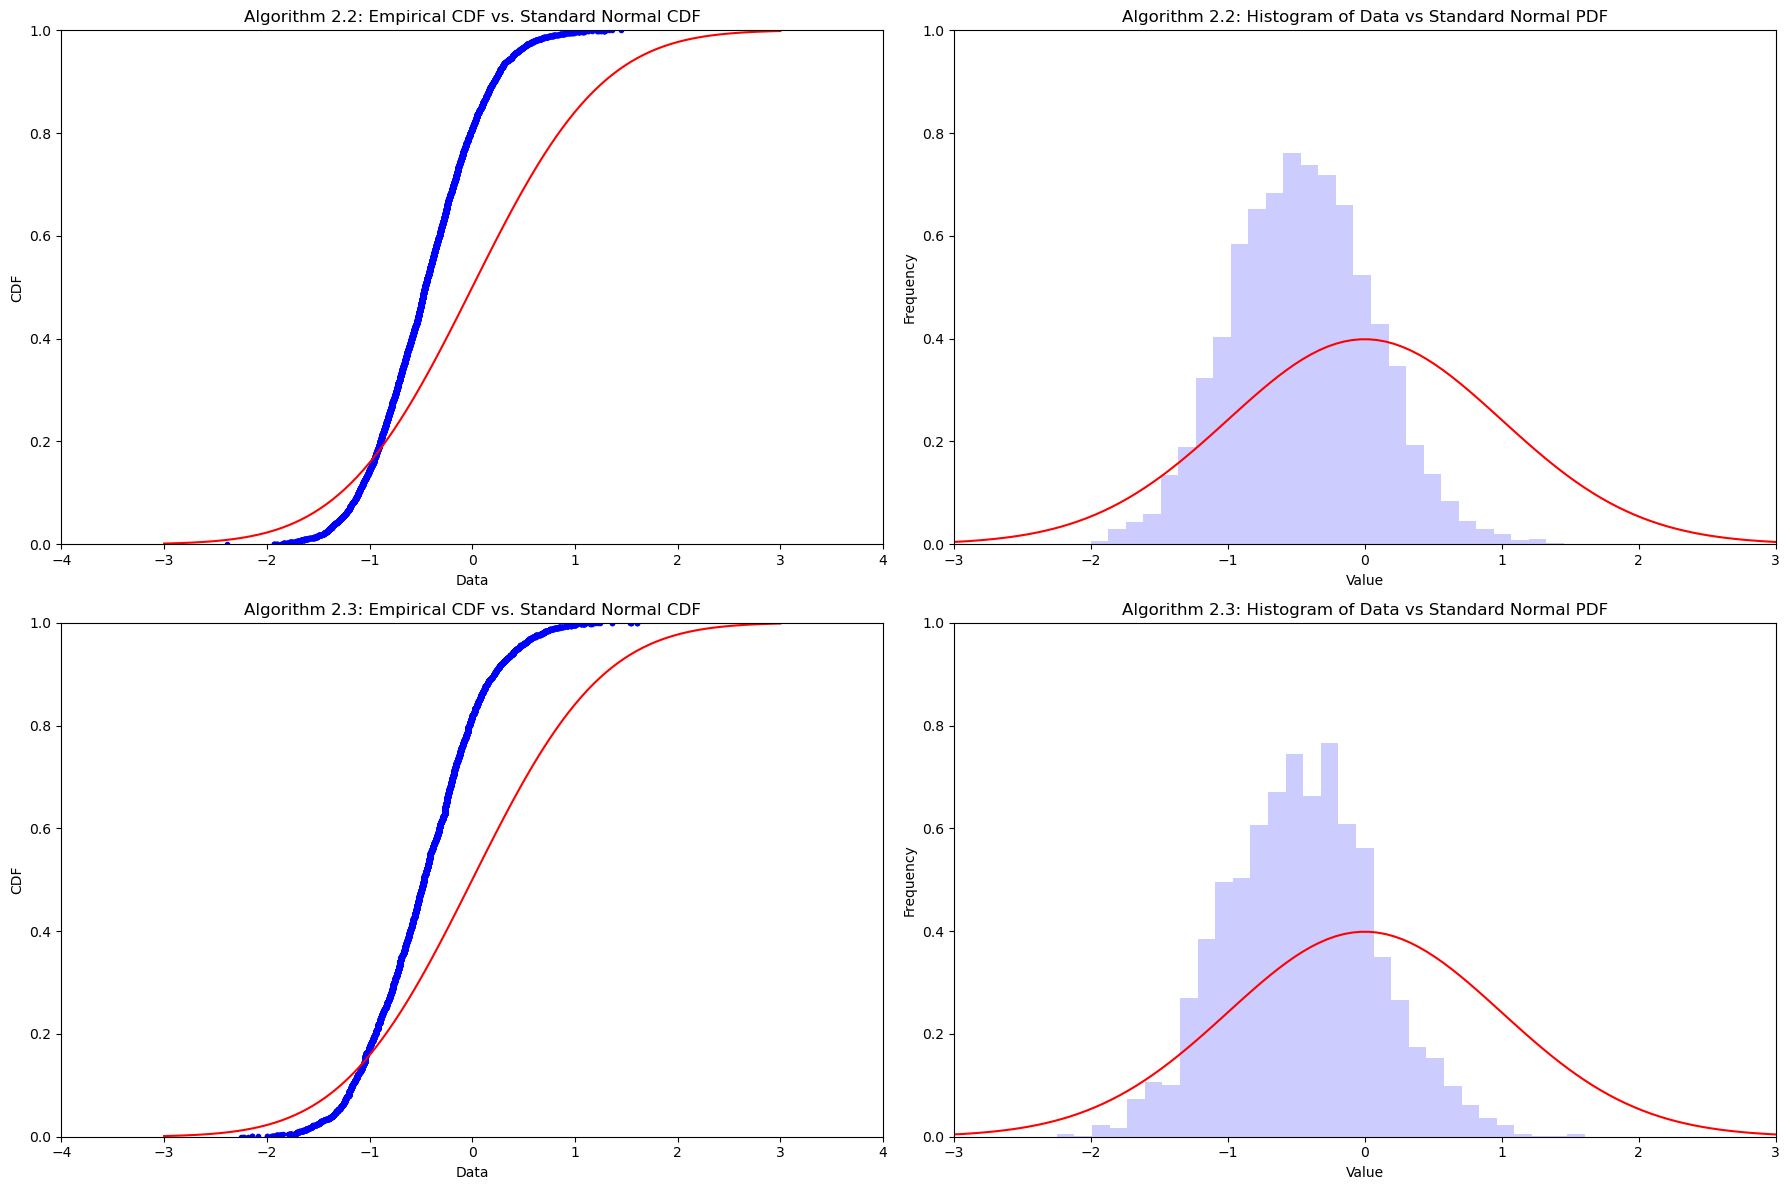

In [43]:
print("t (time) is in not too large")
Compare_densities(X_plot_22[25, :], X_plot_23[25, :])


t (time) is large


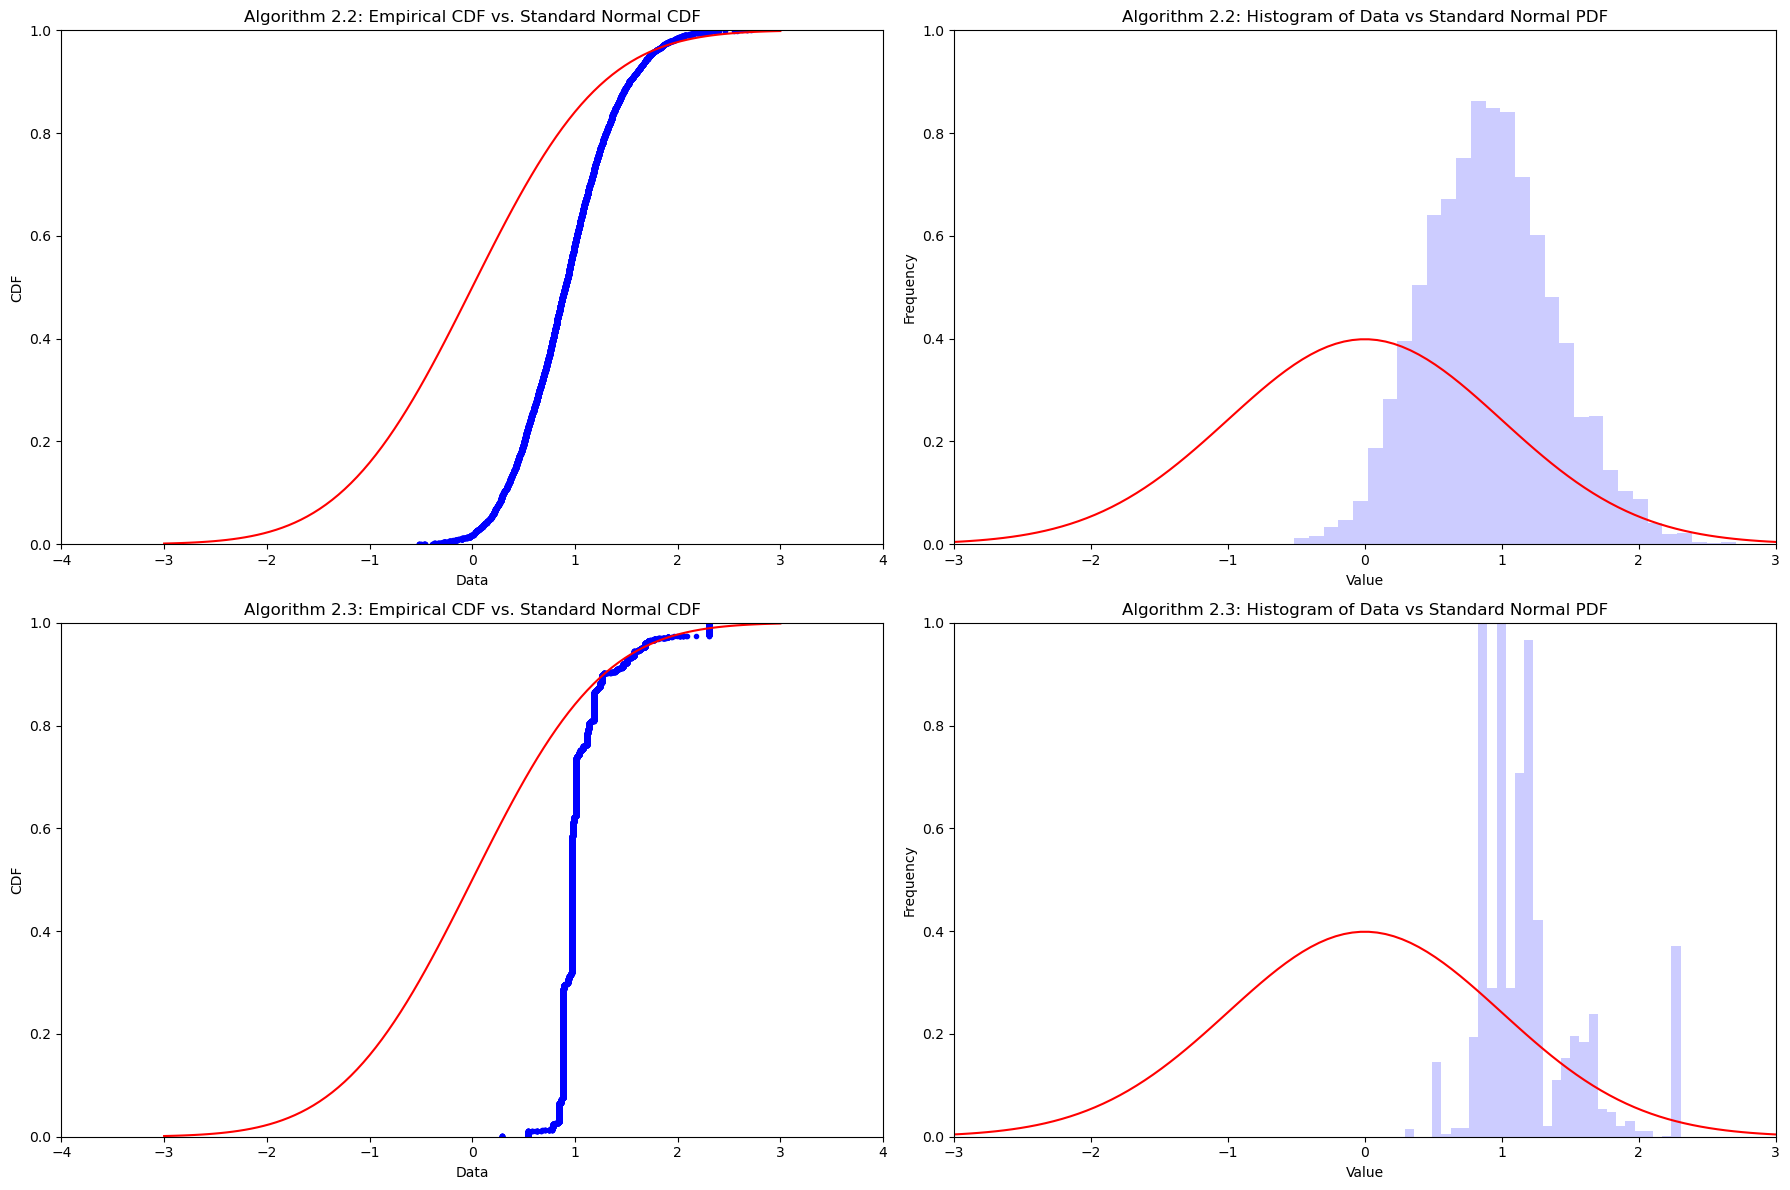

In [44]:
print("t (time) is large")
Compare_densities(X_plot_22[99, :], X_plot_23[99, :])




<font color="red">**Note:**</font> The CDF and PDF plotted in red are not the true distribution that we are trying to approximate. They are just the CDF and PDF of a standard normal distribution given for comparison. This will make it easier to get a sense of the mean, variance, kurtosis, and skewness of the approximated distribution by simply looking at it.

The three blocks above plot the empirical CDF and the histogram of the filtered variable according to Algorithm 2.2 and Algorithm 2.3 at three different times to illustrate the weight degeneraci problem. Click [here](#Interactive_plot_2_go_back) to go back to the text.

<a id="Interactive_plot_3"></a>

### Interactive Plot 3: Applying the Model to Real Data (Section 6)

Click [here](#Interactive_plot_3_go_back) to go back.

t = 1


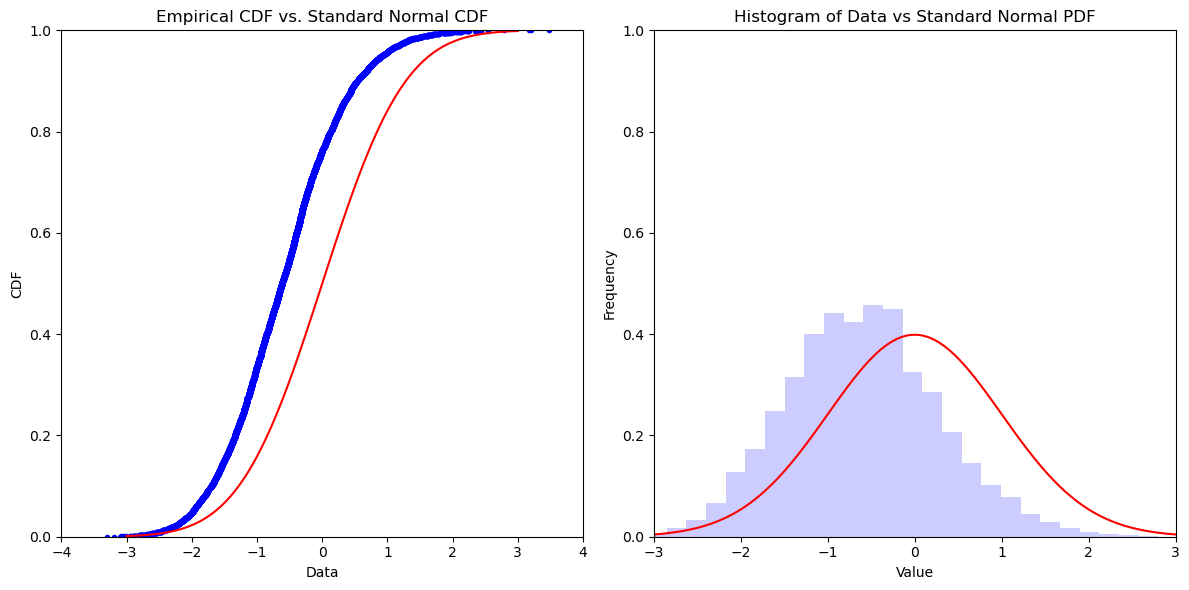

In [45]:
print("t = 1")
plot_ecdf(x_filtered_sp500[1, :], hist=True)


t = 1200


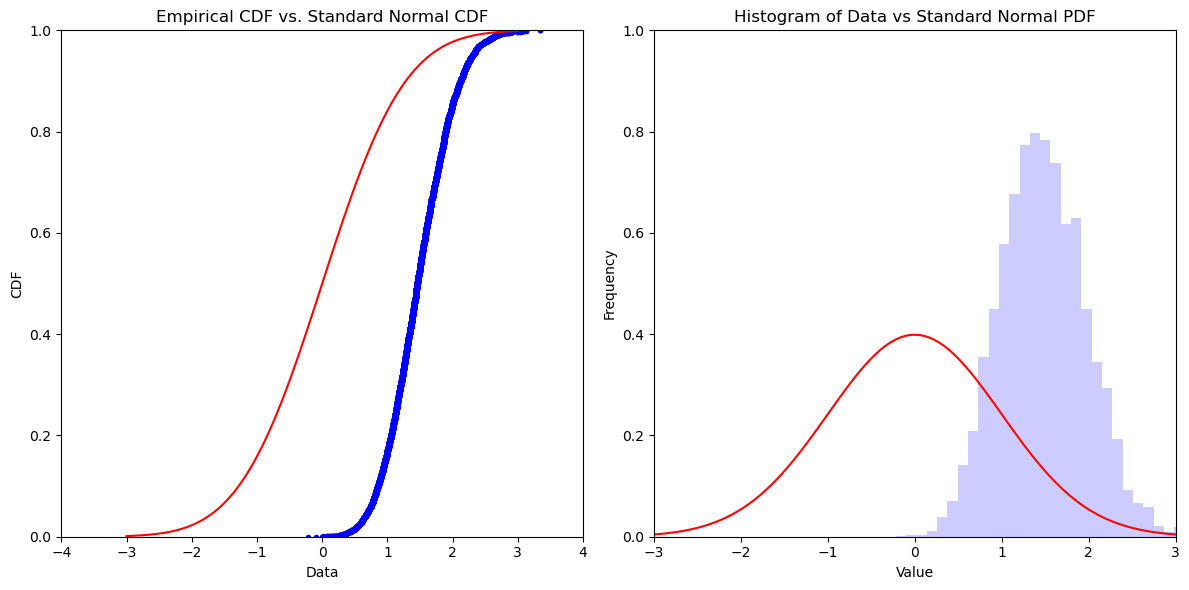

In [46]:
print("t = 1200")
plot_ecdf(x_filtered_sp500[1201, :], hist=True)




<font color="red">**Note:**</font> The CDF and PDF plotted in red are not the true distribution that we are trying to approximate. They are just the CDF and PDF of a standard normal distribution given for comparison. This will make it easier to get a sense of the mean, variance, kurtosis, and skewness of the approximated distribution by simply looking at it.

## References


Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics, 31*(3), 307–327. DOI: 10.1016/0304-4076(86)90063-1


Chen, Z. S. (2003). Bayesian Filtering: From Kalman Filters to Particle Filters, and Beyond. *Statistics: A Journal of Theoretical and Applied Statistics, 182*(1). DOI:10.1080/02331880309257


Creal, D. (2012). A Survey of Sequential Monte Carlo Methods for Economics and Finance. *Econometric Reviews, 31*(3), 245–296. [Link](https://econpapers.repec.org/article/tafemetrv/v_3a31_3ay_3a2012_3ai_3a3_3ap_3a245-296.htm)


Elliott, G., & Timmermann, A. (2016). Economic forecasting. Princeton University Press.


Engle, R. (1982). Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of UK Inflation. *Econometrica, 50*, 987-1008.

Hull, J. (2012). Options, futures, and other derivatives. Prentice Hall.

Kahn, H., & Marshall, A. W. (1953). Methods of Reducing Sample Size in Monte Carlo Computations. Journal of the Operations Research Society of America, 1(5), 263–278. https://www.jstor.org/stable/166789

Klaas, M., Briers, M., Nando de Freitas, Doucet, A., Maskell, S., & Lang, D. (2006). Fast particle smoothing. https://doi.org/10.1145/1143844.1143905

Kloek, T., & van Dijk, H. K. (1978). Bayesian Estimates of Equation System Parameters: An Application of Integration by Monte Carlo. Econometrica, 46(1), 1. https://doi.org/10.2307/1913641

Taylor, S. J. (1982). Financial Returns Modelled by the Product of Two Stochastic Processes— A Study of the Daily Sugar Prices 1961-75. In O. D. Anderson (Ed.), *Time Series Analysis Theory and Practice 1* (pp. 203-226). North-Holland. - [Reference Link](https://www.scirp.org/reference/referencespapers?referenceid=3083232)

Wasserman, L. (2004). All of Statistics. In Springer Texts in Statistics. Springer New York. https://doi.org/10.1007/978-0-387-21736-9

